In [22]:
import joblib
joblib.cpu_count()

32

In [2]:
# got rid of memory issue bugs with gc.collect()
import gc


# !pip install --upgrade pip

from joblib import Parallel, delayed

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import dataclasses
from sklearn.svm import OneClassSVM
from dataclasses import asdict
from tqdm import tqdm
import warnings
import random
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA
from sklearn.decomposition import PCA
from sklearn.pipeline import Pipeline
from sklearn.feature_selection import VarianceThreshold # Feature selector
import ast

pd.plotting.register_matplotlib_converters()
import matplotlib.pyplot as plt
import seaborn as sns


# Global utitlity functions are in separate notebook
%run ./Classification_utility-functions.ipynb
%run ./SEED-CONSTANTS.ipynb

np.random.seed(SEED)
print(f"Numpy Seed was set to: {SEED}")

# change this constant when testing
FINAL_EXP_RESULTS_PATH="clip=False_experiments_results"


SAVE_PATH_NAME="SCNN_trained_models"
CLASSIFIER_TYPE_LST=["OCSVM", "kNN", "LOF"]
WINDOW_SIZE_LST = [125, 250, 500, 750, 1000]#, 1250, 1500]#[125, 250, 500, 750, 1000, 1250, 1500, 1750, 2000]
OVERLAP=0.5

# TRAINING_CONFIG_DICT_FILE_NAME="model_archi_performance_lr_dict.json"
# TRAINING_CONFIG_DICT_FILE_NAME="results_dict_1000-SCNN_3_1_conv_1_dense_arg_dict_default20230702-054339.json"

# TRAINING_CONFIG_DICT_FILE_NAME="results_dict_1000-SCNN_3_1_conv_1_dense_arg_dict_default20230708-061921.json"
# TRAINING_CONFIG_DICT_FILE_NAME="results_dict_1000-SCNN_3_1_conv_1_dense_arg_dict_default20230714-055018.json"#margin=.5
# TRAINING_CONFIG_DICT_FILE_NAME="results_dict_1000-SCNN_3_1_conv_1_dense_arg_dict_default20230714-065735.json"#margin=.1
# TRAINING_CONFIG_DICT_FILE_NAME="results_dict_1000-SCNN_3_1_conv_1_dense_arg_dict_default20230714-071551.json"#margin=.25
# TRAINING_CONFIG_DICT_FILE_NAME="results_dict_1000-SCNN_3_1_conv_1_dense_arg_dict_default20230714-085935.json"

TRAINING_CONFIG_DICT_FILE_NAME_CV_DICT={\
                                        "Butter":
                                        {0: "results_dict_Butter33-cv0-1000-SCNN_3_123_conv_1_dense_arg_dict_default_thesis.json",
                                         1: "results_dict_Butter33-cv1-1000-SCNN_3_123_conv_1_dense_arg_dict_default_thesis.json",
                                         2: "results_dict_Butter33-cv2-1000-SCNN_3_123_conv_1_dense_arg_dict_default_thesis.json",
                                        },
                                        "Butter-EMA":
                                        {0: "results_dict_Butter33-EMA20-cv0-1000-SCNN_3_123_conv_1_dense_arg_dict_default_thesis.json",
                                         1: "results_dict_Butter33-EMA20-cv1-1000-SCNN_3_123_conv_1_dense_arg_dict_default_thesis.json",
                                         2: "results_dict_Butter33-EMA20-cv2-1000-SCNN_3_123_conv_1_dense_arg_dict_default_thesis.json",
                                        },
                                        "Butter-SMA":
                                        {0: "results_dict_Butter33-SMA20-cv0-1000-SCNN_3_123_conv_1_dense_arg_dict_default_thesis.json",
                                         1: "results_dict_Butter33-SMA20-cv1-1000-SCNN_3_123_conv_1_dense_arg_dict_default_thesis.json",
                                         2: "results_dict_Butter33-SMA20-cv2-1000-SCNN_3_123_conv_1_dense_arg_dict_default_thesis.json",
                                        },
                                        
}


TRAINING_CONFIG_DICT_FOLDER_PATH="siamese_cnn_results_final"
# with open(f"{TRAINING_CONFIG_DICT_FOLDER_PATH}/{TRAINING_CONFIG_DICT_FILE_NAME}", 'r') as file:
#     TRAINING_CONFIG_DICT=json.load(file)
    
    
print("Setup Complete")

SEED: 567
FINAL_EXP_RESULTS_PATH: clip=False_experiments_results
--------------------SEED and CONSTANTS imported--------------------
SEED: 567
Python 3.9.10
EER: 0.333, Threshold: 0.600 <-- Arbitrary case
EER: 0.000, Threshold: 0.900 <-- Best case
EER: 1.000, Threshold: 0.900 <-- Worse case
EER: 0.400, Threshold: 0.200 <-- Worse case
EER: 0.167, Threshold: 0.600 <-- Arbitrary case
EER: 0.000, Threshold: 0.900 <-- Best case
EER: 1.000, Threshold: 0.900 <-- Worse case
EER: 0.333, Threshold: 1.000 <-- Worse case
--------------------Utility functions imported--------------------
SEED: 567
FINAL_EXP_RESULTS_PATH: clip=False_experiments_results
--------------------SEED and CONSTANTS imported--------------------
SEED: 567
Python 3.9.10
--------------------Preprocessing utility functions imported--------------------
SEED: 567
FINAL_EXP_RESULTS_PATH: clip=False_experiments_results
--------------------SEED and CONSTANTS imported--------------------
SEED: 567
Python 3.9.10
--------------------Neu

In [3]:
import sklearn
sklearn.__dir__()
sklearn.__version__

'1.0.2'

In [4]:
@dataclasses.dataclass
class ExperimentParameters:
    """Contains all relevant parameters to run an experiment."""

    name: str  # Name of Parameter set. Used as identifier for charts etc.
    frequency: int
    max_subjects: int
    max_test_subjects: int
        
    user_ids: list
    num_sample_points_per_exp: int
    exp_begin_cutoff_idx: int
    exp_end_cutoff_idx: int
        
    
    seconds_per_subject_train: float
    seconds_per_subject_test: float
    window_size: int  # After resampling
    ocsvm_step_width: int  # After resampling
    scaler: str  # StandardScaler, MinMaxScaler, Normalizer, MaxAbsScaler, RobustScaler, PowerTransformer
    scaler_scope: str  # {"subject", "session"}
    scaler_global: bool  # fit transform scale on all data (True) or fit on training only (False)
    ocsvm_kernel: str # ocsvm kernel
    ocsvm_nu: float  # Best value found in random search, used for final model
    ocsvm_gamma: float  # Best value found in random search, used for final model
    feature_cols: list  # Columns used as features
    exclude_subjects: list  # Don't load data from those users
        
    # Calculated values
    def __post_init__(self):
        # HDF key of table:
        self.table_name = f"sensors_{self.frequency}hz"

        

# INSTANCES
# ===========================================================

# NAIVE_APPROACH
# -----------------------------------------------------------
NAIVE_MINMAX_OCSVM = ExperimentParameters(
    name="NAIVE-MINMAX_OCSVM",
    frequency=100,
    max_subjects=29,
    max_test_subjects=10,
    user_ids = [1, 2, 3, 4, 5, 6, 7, 8, 19, 21, 22, 26, 27, 28, 29, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 48, 49],
    num_sample_points_per_exp=21000,
    exp_begin_cutoff_idx=500,
    exp_end_cutoff_idx=-500,
    seconds_per_subject_train=210,
    seconds_per_subject_test=210,    
    window_size=250,
    ocsvm_step_width=250,
    scaler="minmax",
    scaler_scope="subject",
    scaler_global=True,
    ocsvm_kernel="rbf",
    ocsvm_nu=None,
    ocsvm_gamma=None,
    feature_cols=[
        "x_a",
        "y_a",
        "z_a",
        "x_g",
        "y_g",
        "z_g",
    ],
    exclude_subjects=[],
)

# VALID_APPROACH
# -----------------------------------------------------------
VALID_MINMAX_OCSVM = dataclasses.replace(
    NAIVE_MINMAX_OCSVM,
    name="VALID-MINMAX-OCSVM",
    scaler_global=False,
    ocsvm_nu=0.165,
    ocsvm_gamma=0.039,
)

# NAIVE_ROBUST_APPROACH
# -----------------------------------------------------------
NAIVE_ROBUST_OCSVM = dataclasses.replace(
    NAIVE_MINMAX_OCSVM,
    name="NAIVE-ROBUST-OCSVM",
    scaler="robust",
    scaler_global=True,
    ocsvm_nu=0.153,
    ocsvm_gamma=0.091,  # below median, selected by chart
)

# ROBUST_APPROACH (VALID)
# -----------------------------------------------------------
VALID_ROBUST_OCSVM_125 = dataclasses.replace(
    NAIVE_MINMAX_OCSVM,
    name="VALID-ROBUST-OCSVM",
    scaler="RobustScaler",
    scaler_global=False,
    window_size=125
#     ocsvm_nu=0.037,
#     ocsvm_gamma= 0.001,
)


VALID_ROBUST_OCSVM_250 = dataclasses.replace(
    NAIVE_MINMAX_OCSVM,
    name="VALID-ROBUST-OCSVM",
    scaler="RobustScaler",
    scaler_global=False,
    window_size=250
#     ocsvm_nu=0.037,
#     ocsvm_gamma= 0.001,
)

VALID_ROBUST_OCSVM_500 = dataclasses.replace(
    NAIVE_MINMAX_OCSVM,
    name="VALID-ROBUST-OCSVM",
    scaler="RobustScaler",
    scaler_global=False,
    window_size=500
#     ocsvm_nu=0.037,
#     ocsvm_gamma= 0.001,
)

VALID_ROBUST_OCSVM_750 = dataclasses.replace(
    NAIVE_MINMAX_OCSVM,
    name="VALID-ROBUST-OCSVM",
    scaler="RobustScaler",
    scaler_global=False,
    window_size=750
#     ocsvm_nu=0.037,
#     ocsvm_gamma= 0.001,
)

VALID_ROBUST_OCSVM_1000 = dataclasses.replace(
    NAIVE_MINMAX_OCSVM,
    name="VALID-ROBUST-OCSVM",
    scaler="RobustScaler",
    scaler_global=False,
    window_size=1000
#     ocsvm_nu=0.037,
#     ocsvm_gamma= 0.001,
)

VALID_ROBUST_OCSVM_1250 = dataclasses.replace(
    NAIVE_MINMAX_OCSVM,
    name="VALID-ROBUST-OCSVM",
    scaler="RobustScaler",
    scaler_global=False,
    window_size=1250
#     ocsvm_nu=0.037,
#     ocsvm_gamma= 0.001,
)

VALID_ROBUST_OCSVM_1500 = dataclasses.replace(
    NAIVE_MINMAX_OCSVM,
    name="VALID-ROBUST-OCSVM",
    scaler="RobustScaler",
    scaler_global=False,
    window_size=1500
#     ocsvm_nu=0.037,
#     ocsvm_gamma= 0.001,
)

VALID_ROBUST_OCSVM_1750 = dataclasses.replace(
    NAIVE_MINMAX_OCSVM,
    name="VALID-ROBUST-OCSVM",
    scaler="RobustScaler",
    scaler_global=False,
    window_size=1750
#     ocsvm_nu=0.037,
#     ocsvm_gamma= 0.001,
)

VALID_ROBUST_OCSVM_2000 = dataclasses.replace(
    NAIVE_MINMAX_OCSVM,
    name="VALID-ROBUST-OCSVM",
    scaler="RobustScaler",
    scaler_global=False,
    window_size=2000
#     ocsvm_nu=0.037,
#     ocsvm_gamma= 0.001,
)

# NORMALIZER_APPROACH (VALID)
# -----------------------------------------------------------
VALID_NORMALIZER_OCSVM = dataclasses.replace(
    NAIVE_MINMAX_OCSVM,
    name="VALID-NORMALIZER-OCSVM",
    scaler="Normalizer",
    scaler_global=False,
    ocsvm_nu=0.074,
    ocsvm_gamma= 0.029,
)

In [5]:
P = VALID_ROBUST_OCSVM_2000
P.ocsvm_step_width = int(P.window_size * .5)

P.model_variant = 'multi_head_fcn'

P.filter_order=10
P.sampling_freq=100
P.filtfilt=1
P.cut_off_freq=33

In [6]:
# P.smoothing = "Butterworth"


# preprocessing_method="Realworld-per_unknown_window"
# for clf_type in CLASSIFIER_TYPE_LST:
#     rival_test_hyperparameters_file_name=f"{FINAL_EXP_RESULTS_PATH}/WACA-{clf_type}/{P.smoothing}_Mean_EER_{preprocessing_method}_df_test_dict_raw_df.json"
#     rival_test_hyperparameters_df = pd.read_json(rival_test_hyperparameters_file_name)
#     print(rival_test_hyperparameters_df["cut_off_freq"])


In [7]:
utils_ppp(P)

,Value
name,VALID-ROBUST-OCSVM
frequency,100
max_subjects,29
max_test_subjects,10
user_ids,"[1, 2, 3, 4, 5, 6, 7, 8, 19, 21, 22, 26, 27, 2..."
num_sample_points_per_exp,21000
exp_begin_cutoff_idx,500
exp_end_cutoff_idx,-500
seconds_per_subject_train,210
seconds_per_subject_test,210


In [8]:
utils_eer_scorer

make_scorer(utils_eer, greater_is_better=False)

In [9]:
#include 47 later
# user_ids = [9]
df_exps_dict = load_data_frames(P.user_ids, P.exp_begin_cutoff_idx, P.exp_end_cutoff_idx, P.num_sample_points_per_exp)
raw_dfList_exp1, raw_dfList_exp2 = df_exps_dict['dfList_exp1'], df_exps_dict['dfList_exp2']

Loading exp1 data:
1) accel_count: 28388, gyro_count: 31997
2) accel_count: 26010, gyro_count: 28954
3) accel_count: 28227, gyro_count: 31814
4) accel_count: 24860, gyro_count: 26105
5) accel_count: 24270, gyro_count: 24347
6) accel_count: 25012, gyro_count: 25060
7) accel_count: 25301, gyro_count: 25382
8) accel_count: 21975, gyro_count: 21658
19) accel_count: 24110, gyro_count: 25050
21) accel_count: 24326, gyro_count: 23809
22) accel_count: 29123, gyro_count: 28724
26) accel_count: 23148, gyro_count: 24291
27) accel_count: 24299, gyro_count: 23589
28) accel_count: 23807, gyro_count: 24523
29) accel_count: 24030, gyro_count: 23457
35) accel_count: 24388, gyro_count: 23673
36) accel_count: 24228, gyro_count: 24208
37) accel_count: 31945, gyro_count: 31816
38) accel_count: 22135, gyro_count: 22327
39) accel_count: 23573, gyro_count: 23459
40) accel_count: 23057, gyro_count: 24296
41) accel_count: 24102, gyro_count: 23681
42) accel_count: 24074, gyro_count: 24328
43) accel_count: 22631,

In [10]:
randomized_data_idx = list(range(len(P.user_ids)))
random.Random(SEED).shuffle(randomized_data_idx)
split_idx = 2 * (len(randomized_data_idx)//3) + 1
train_set = randomized_data_idx[: split_idx]
test_set = randomized_data_idx[split_idx: ]
# train_set = randomized_data_idx
print(f"train_set: {train_set}\ntest_set: {test_set}")
# train_set = test_set
# test_set = train_set
print(f"train_set: {train_set}\ntest_set: {test_set}")

train_set: [7, 24, 8, 11, 13, 19, 28, 21, 26, 3, 20, 22, 6, 25, 16, 1, 17, 27, 5]
test_set: [0, 12, 14, 9, 18, 23, 2, 15, 10, 4]
train_set: [7, 24, 8, 11, 13, 19, 28, 21, 26, 3, 20, 22, 6, 25, 16, 1, 17, 27, 5]
test_set: [0, 12, 14, 9, 18, 23, 2, 15, 10, 4]


In [11]:
num_sample_points_per_exp_user_47 = 18000
df_exps_dict_user_47 = load_data_frames([47], P.exp_begin_cutoff_idx, P.exp_end_cutoff_idx, num_sample_points_per_exp_user_47)
dfList_exp1_user_47, dfList_exp2_user_47 = df_exps_dict_user_47['dfList_exp1'], df_exps_dict_user_47['dfList_exp2']

raw_dfList_exp1_user_47 = dfList_exp1_user_47
raw_dfList_exp2_user_47 = dfList_exp2_user_47

Loading exp1 data:
47) accel_count: 22777, gyro_count: 22226
Loading exp2 data:
47) accel_count: 17718, gyro_count: 18353


In [12]:
print(f"train_set: {train_set}")
# print(f"X_exp1_train_dic: {X_exp1_train_dic.keys()}")
# print(f"X_exp2_train_dic: {X_exp2_train_dic.keys()}")

train_set: [7, 24, 8, 11, 13, 19, 28, 21, 26, 3, 20, 22, 6, 25, 16, 1, 17, 27, 5]


In [13]:
print(f"test_set: {test_set}")
# print(f"X_exp1_test_dic: {X_exp1_test_dic.keys()}")
# print(f"X_exp2_test_dic: {X_exp2_test_dic.keys()}")

test_set: [0, 12, 14, 9, 18, 23, 2, 15, 10, 4]


In [14]:
def custom_save_model_exp_notebook(model,
                                   model_classifier_type, exp_num, archi_name, winsize, 
                                   arg_dict, loss_record_dict, metric_record_dict, other_dict=None, save_name_suffix=''):
    """EXP_PATH_NAME
    save the deep learning feature extractor model, along with dictionary of arguments as a json,
    best epoch found, a dictionary containing the accurcy and EER figures, and the window size, and
    a dicgionary of validation and training loss values over time that can be later plotted.
    inputs: 
    deep_feature_model: tf model
    arg_dict: serializable dictionary
    test_res_fig_dic: dict containing keys {"acc", "eer"}
    win_size: int
    loss_record_dict
    """
        
    base_path=f"{FINAL_EXP_RESULTS_PATH}/{SAVE_PATH_NAME}/{model_classifier_type}/{exp_num}"
    path_to_archi_name=base_path+f"/{archi_name}"
    final_path=path_to_archi_name+f"/{winsize}"
    
    if not os.path.isdir(base_path):
        raise Exception(f"Base path does not exist: {base_path}")
        
    if not os.path.isdir(path_to_archi_name):
        os.mkdir(path_to_archi_name)

    if not os.path.isdir(final_path):
        os.mkdir(final_path)
        
    model.save(final_path+f"/{model_classifier_type}-{exp_num}-{archi_name}-{winsize}-model-{save_name_suffix}")
    deep_feature_model = extract_deep_feature_extactor(model)
    deep_feature_model.save(final_path+f"/{model_classifier_type}-{exp_num}-{archi_name}-{winsize}-deep_feature_extractor-{save_name_suffix}")
    
    
    with open(f"{final_path}/arg_dict-{save_name_suffix}.json", 'w') as file:
        arg_dict_json = json.dumps(arg_dict)
        file.write(arg_dict_json)
        
    with open(f"{final_path}/loss_record-{save_name_suffix}.json", 'w') as file:
        loss_record_json = json.dumps(loss_record_dict)
        file.write(loss_record_json)
        
    with open(f"{final_path}/metric_record-{save_name_suffix}.json", 'w') as file:
        metric_record_json = json.dumps(metric_record_dict)
        file.write(metric_record_json)
    
    if other_dict != None:
        with open(f"{final_path}/other_dict-{save_name_suffix}.json", 'w') as file:
            other_dict_json = json.dumps(other_dict)
            file.write(other_dict_json)

        
    fig_dict = utils_plot_validation_metric(metric_record_dict)
    for metric in fig_dict:
        fig = fig_dict[metric]
        fig.savefig(f'{final_path}/{metric}_epoch-{save_name_suffix}.svg', bbox_inches='tight')
    
    print(f"saved model at {final_path}")

In [15]:
# np.logspace(-4, -1, 50)

In [16]:
# init_experiment_params(exp_config=P)


In [17]:
def measure_optimal_lr_epoch_dict(loss_record_dict, lr_epoch_log_dict):

    min_val = min(loss_record_dict['val_loss'])
    min_val_index=loss_record_dict['val_loss'].index(min_val)
    print(f"loss_record_dict: {loss_record_dict['val_loss']}, min_val_index: {min_val_index}")

    optimal_lr_epoch_dict={}
    for i in range(min_val_index+1):
        optimal_lr_epoch_dict[i] = lr_epoch_log_dict[i]

    return optimal_lr_epoch_dict

In [19]:
def model_training_with_training_config_dict(dfList_dict, window_size_lst, train_set, exp_config, overlap, training_config_dict, save_info_dict):
    
    model_classifier_type = save_info_dict["model_classifier_type"]
    exp_num = save_info_dict["exp_num"]
    cv_fold_idx = save_info_dict["cv_fold_idx"]

    for window_size in tqdm(window_size_lst):

        np.random.seed(SEED)
        tf.random.set_seed(SEED)
        print(f"Seed was set to: {SEED}")

        if str(window_size) in training_config_dict:
            winsize_training_config_dict=training_config_dict[str(window_size)]
        else:
            raise Exception("Window size not in training_config_dict")

        exp_config.window_size=window_size
        exp_config.nn_step_width = int(exp_config.window_size * overlap)

        
        dfList_exp1=dfList_dict["dfList_exp1"]
        dfList_exp2=dfList_dict["dfList_exp2"]
        
        if 29 in train_set:
            dfList_exp1_user_47=dfList_dict["dfList_exp1_user_47"]
            dfList_exp2_user_47=dfList_dict["dfList_exp2_user_47"]


        # separate user 47 which has 29 index by default from the other users as 47 has shorter time series
        if 29 in train_set:

            user_idx_set_without_user_47 = train_set - {29}

        else:

            user_idx_set_without_user_47 = train_set


        X_train_exp1_dict, X_train_exp2_dict, fitted_scaler_train_exp2_dict=get_raw_windows(dfList_exp1=dfList_exp1,
                                                                                            dfList_exp2=dfList_exp2,
                                                                                            window_size=window_size, 
                                                                                            step_width=exp_config.nn_step_width, 
                                                                                            user_idx_set=user_idx_set_without_user_47, 
                                                                                            scaler=exp_config.scaler, 
                                                                                            num_sample_points_per_exp=exp_config.num_sample_points_per_exp, 
                                                                                            EMA_per_win_span=exp_config.EMA_per_win_span, 
                                                                                            SMA_per_win_winsize=exp_config.SMA_per_win_winsize,
                                                                                            Butter_per_win_argdict=exp_config.Butter_per_win_argdict, 
                                                                                            verbose=0)

        if 29 in train_set:
        # user 47 with index 29 is not present in the first cv fold
            X_train_exp1_dict_user_47, X_train_exp2_dict_user_47, fitted_scaler_train_exp2_dict_user_47=get_raw_windows_user_47(dfList_exp1_user_47=dfList_exp1_user_47,
                                                                                                                                dfList_exp2_user_47=dfList_exp2_user_47, 
                                                                                                                                window_size=window_size, 
                                                                                                                                step_width=exp_config.nn_step_width, 
                                                                                                                                scaler=exp_config.scaler, 
                                                                                                                                num_sample_points_per_exp=exp_config.num_sample_points_per_exp, 
                                                                                                                                EMA_per_win_span=exp_config.EMA_per_win_span, 
                                                                                                                                SMA_per_win_winsize=exp_config.SMA_per_win_winsize,
                                                                                                                                Butter_per_win_argdict=exp_config.Butter_per_win_argdict, 
                                                                                                                                verbose=0)

            X_train_exp1_dict, X_train_exp2_dict, fitted_scaler_train_exp2_dict=append_user_47_to_data(X_exp1_dict=X_train_exp1_dict, 
                                                                                                       X_exp2_dict=X_train_exp2_dict, 
                                                                                                       fitted_scaler_exp2_dict=fitted_scaler_train_exp2_dict, 
                                                                                                       all_user_set=user_idx_set_without_user_47, 
                                                                                                       X_exp1_dict_user_47=X_train_exp1_dict_user_47, 
                                                                                                       X_exp2_dict_user_47=X_train_exp2_dict_user_47, 
                                                                                                       fitted_scaler_exp2_dict_user_47=fitted_scaler_train_exp2_dict_user_47, 
                                                                                                       verbose=0)
            #--------------------

        num_pair_limit=3*(NUM_PAIR_LIMIT_TRAIN_2000+NUM_PAIR_LIMIT_VALID_2000)

        # train_pairs_dict = prep_X_y_pair(X_train_exp2_dict, X_train_exp1_dict, list(X_train_exp2_dict.keys()), fitted_scaler_train_exp2_dict, num_pair_limit=num_pair_limit)

        train_pairs_dict = prep_X_y_pair_robust_minmax(X_exp2_dic=X_train_exp2_dict, 
                                                       X_exp1_dic=X_train_exp1_dict, 
                                                       user_id_list=list(X_train_exp2_dict.keys()), 
                                                       fitted_raw_Robust_scaler_dict=fitted_scaler_train_exp2_dict, 
                                                       is_train=True, # this will include -1 samples
                                                       num_pair_limit=num_pair_limit)

        X_train, y_train, X_train_distro_dic = train_pairs_dict["X"], train_pairs_dict["y"], train_pairs_dict["X_dic"]


        # 2D Filter Model needs flat 4th dimension
        if exp_config.model_variant == "2d":
            X_train[0] = X_train[0].reshape((*X_train[0].shape, 1))
            X_train[1] = X_train[1].reshape((*X_train[1].shape, 1))

        print(
            f"Training samples:   {y_train.shape[0]}, shape: {X_train[0].shape},"
            + f" class balance: {np.unique(y_train, return_counts=True)}"
        )



        for archi_name in tqdm(winsize_training_config_dict):
            np.random.seed(SEED)
            tf.random.set_seed(SEED)
            print(archi_name)
            archi_dict=winsize_training_config_dict[archi_name]
            arg_dict=archi_dict["arg_dict"]

            archi_lr_epoch_log_dict=ast.literal_eval(archi_dict["lr_epoch_log_dict"])
            archi_loss_record_dict=archi_dict["loss_record_dict"]
            optimal_lr_epoch_dict=measure_optimal_lr_epoch_dict(archi_loss_record_dict, archi_lr_epoch_log_dict)

            print(archi_lr_epoch_log_dict)
            print(archi_loss_record_dict)
            print(optimal_lr_epoch_dict)


            create_model_func = get_create_model_func(exp_config.model_variant, exp_config.window_size, exp_config.feature_cols)

            print(arg_dict)
            loss_record_dict = {'loss': [], 'val_loss': []}
            metric_record_dict = {}
            model = create_model_func(arg_dict)

            # Train
            history = model.fit(
                x=X_train,
                y=y_train,
                batch_size=arg_dict["batch_size"],
                epochs=len(optimal_lr_epoch_dict), #depends on the len optimal_lr_epoch_dict
                verbose=1,
                shuffle=True,
                callbacks=[MetricsCallback((None, None, X_train, y_train), loss_record_dict=loss_record_dict, metric_record_dict=metric_record_dict, 
                                           epoch_evaluate_freq=10, save_plots=False, print_interm_epochs=False, early_stoping=False, 
                                           optimal_lr_epoch_dict=optimal_lr_epoch_dict,
                                           verbose=0)],
            )
            print(loss_record_dict)
            print("Training History:")
            loss_fig = utils_plot_training_loss(loss_record_dict)



            custom_save_model_exp_notebook(model=model,
                                           model_classifier_type=model_classifier_type, exp_num=exp_num, archi_name=archi_name, winsize=window_size, 
                                           arg_dict=arg_dict, loss_record_dict=loss_record_dict, metric_record_dict=metric_record_dict, 
                                           other_dict=None, save_name_suffix=f"Butter33-SMA20-cv{cv_fold_idx}")
            del model
            del history
            K.clear_session()
            tf.compat.v1.reset_default_graph()

            gc.collect()

In [20]:
def get_training_config_dict(prep_type, cv_fold_idx):
    with open(f"{TRAINING_CONFIG_DICT_FOLDER_PATH}/{TRAINING_CONFIG_DICT_FILE_NAME_CV_DICT[prep_type][cv_fold_idx]}", 'r') as file:
        return json.load(file)
    

# 0. No Smoothing

### Optimizing and TestingFINAL_EXP_RESULTS_PATH

In [ ]:
FINAL_EXP_RESULTS_PATH

'clip=False_experiments_results'

In [27]:
print(f"{WINDOW_SIZE_LST}, {EXP_NUM_0}")
TRAINING_CONFIG_DICT.keys()

[1000], 0


dict_keys(['1000'])

train_set: [7, 24, 8, 11, 13, 19, 28, 21, 26, 3, 20, 22, 6, 25, 16, 1, 17, 27, 5, 47]
test_set: [0, 12, 14, 9, 18, 23, 2, 15, 10, 4]
reseting experiment params successful!


  0%|          | 0/1 [00:00<?, ?it/s]

Seed was set to: 567
len(exp1_df_user_set_dict): 19
len(exp2_df_user_set_dict): 19
len(X_exp1_dict_user_47[47]): 41
len_exp2_user_47: 35
82
0.11869422962522308




  0%|          | 0/20 [00:00<?, ?it/s]

  5%|▌         | 1/20 [00:04<01:22,  4.33s/it]

 10%|█         | 2/20 [00:08<01:17,  4.30s/it]

 15%|█▌        | 3/20 [00:12<01:13,  4.29s/it]

 20%|██        | 4/20 [00:17<01:08,  4.29s/it]

 25%|██▌       | 5/20 [00:21<01:04,  4.30s/it]

 30%|███       | 6/20 [00:25<01:00,  4.29s/it]

 35%|███▌      | 7/20 [00:29<00:55,  4.26s/it]

 40%|████      | 8/20 [00:34<00:51,  4.25s/it]

 45%|████▌     | 9/20 [00:38<00:46,  4.24s/it]

 50%|█████     | 10/20 [00:42<00:42,  4.23s/it]

 55%|█████▌    | 11/20 [00:46<00:38,  4.23s/it]

 60%|██████    | 12/20 [00:51<00:33,  4.22s/it]

 65%|██████▌   | 13/20 [00:55<00:29,  4.22s/it]

 70%|███████   | 14/20 [00:59<00:25,  4.22s/it]

 75%|███████▌  | 15/20 [01:03<00:21,  4.22s/it]

 80%|████████  | 16/20 [01:07<00:16,  4.21s/it]

 85%|████████▌ | 17/20 [01:12<00:12,  4.21s/it]

 90%|█████████ | 18/20 [01:16<00:08,  4.21s/it]

 95%|█████████▌| 19/20 [01:20<00:04,  4.21s/it]

100%|██████████| 20/20 [01:24<00:00,

Training samples:   31920, shape: (31920, 1000, 6), class balance: (array([0., 1.], dtype=float32), array([15960, 15960]))




  0%|          | 0/1 [00:00<?, ?it/s]

SCNN_3_1_conv_1_dense_arg_dict_default
loss_record_dict: [5.552242279052734, 1.502982497215271, 0.38201701641082764, 0.13655543327331543, 0.06939662247896194, 0.056164104491472244, 0.05565778538584709, 0.05511616915464401, 0.0554816909134388, 0.03913825750350952, 0.03986441716551781, 0.03577597811818123, 0.0355619341135025, 0.03560847416520119, 0.034823473542928696, 0.03495441749691963, 0.03474854305386543, 0.03473513945937157, 0.034736793488264084, 0.034705717116594315], min_val_index: 19
{0: 0.001, 1: 0.001, 2: 0.001, 3: 0.001, 4: 0.001, 5: 0.001, 6: 0.001, 7: 0.001, 8: 0.001, 9: 0.00020000001, 10: 0.00020000001, 11: 4.0000003e-05, 12: 4.0000003e-05, 13: 4.0000003e-05, 14: 8.000001e-06, 15: 8.000001e-06, 16: 1.6000001e-06, 17: 1e-06, 18: 1e-06, 19: 1e-06}
{'loss': [9.839420318603516, 3.276033639907837, 0.776054322719574, 0.20073671638965607, 0.09321451932191849, 0.06680723279714584, 0.058947667479515076, 0.057540878653526306, 0.056264474987983704, 0.04310597851872444, 0.0412126109004

2023-07-14 09:02:10.928727: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-07-14 09:02:11.444419: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1510] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 43490 MB memory:  -> device: 0, name: NVIDIA A40, pci bus id: 0000:17:00.0, compute capability: 8.6


================================[ Initial State ]================================

2023-07-14 09:02:16.871792: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)
2023-07-14 09:02:17.820351: I tensorflow/stream_executor/cuda/cuda_dnn.cc:369] Loaded cuDNN version 8101
2023-07-14 09:02:18.575161: I tensorflow/core/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory
2023-07-14 09:02:18.575776: I tensorflow/core/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory
2023-07-14 09:02:18.575792: W tensorflow/stream_executor/gpu/asm_compiler.cc:77] Couldn't get ptxas version string: Internal: Couldn't invoke ptxas --version
2023-07-14 09:02:18.577432: I tensorflow/core/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory
2023-07-14 09:02:18.577498: W tensorflow/stream_executor/gpu/redzone_allocator.cc:314] Internal: Failed to launch ptxas
Relying on driver to perform ptx co


TRAIN: roc_auc: 0.9014, eer: 0.1677, thres: 0.0357 => acc: 0.8323, f1: 0.8323

Epoch 1/20
125/125 [==============================] - 10s 56ms/step - loss: 8.0436
Epoch 2/20
125/125 [==============================] - 8s 62ms/step - loss: 1.2650
Epoch 3/20
125/125 [==============================] - 8s 63ms/step - loss: 0.1659
Epoch 4/20
125/125 [==============================] - 8s 63ms/step - loss: 0.0683
Epoch 5/20
125/125 [==============================] - 8s 63ms/step - loss: 0.0577
Epoch 6/20
125/125 [==============================] - 8s 62ms/step - loss: 0.0561
Epoch 7/20
125/125 [==============================] - 8s 63ms/step - loss: 0.0556
Epoch 8/20
125/125 [==============================] - 8s 62ms/step - loss: 0.0550
Epoch 9/20
125/125 [==============================] - 7s 60ms/step - loss: 0.0543
Epoch 10/20
125/125 [==============================] - 8s 62ms/step - loss: 0.0407
Epoch 11/20
125/125 [==============================] - 8s 64ms/step - loss: 0.0392
Epoch 12/20
125

2023-07-14 09:06:32.034335: W tensorflow/python/util/util.cc:348] Sets are not currently considered sequences, but this may change in the future, so consider avoiding using them.


INFO:tensorflow:Assets written to: clip=False_experiments_results/SCNN_trained_models/SCNN-OCSVM/0/SCNN_3_1_conv_1_dense_arg_dict_default/1000/SCNN-OCSVM-0-SCNN_3_1_conv_1_dense_arg_dict_default-1000-model-optimal_lr-Max_2000x2_linear_1000_margin=0.5/assets
INFO:tensorflow:Assets written to: clip=False_experiments_results/SCNN_trained_models/SCNN-OCSVM/0/SCNN_3_1_conv_1_dense_arg_dict_default/1000/SCNN-OCSVM-0-SCNN_3_1_conv_1_dense_arg_dict_default-1000-deep_feature_extractor-optimal_lr-Max_2000x2_linear_1000_margin=0.5/assets




100%|██████████| 1/1 [04:27<00:00, 267.91s/it]

100%|██████████| 1/1 [05:56<00:00, 356.45s/it]

saved model at clip=False_experiments_results/SCNN_trained_models/SCNN-OCSVM/0/SCNN_3_1_conv_1_dense_arg_dict_default/1000


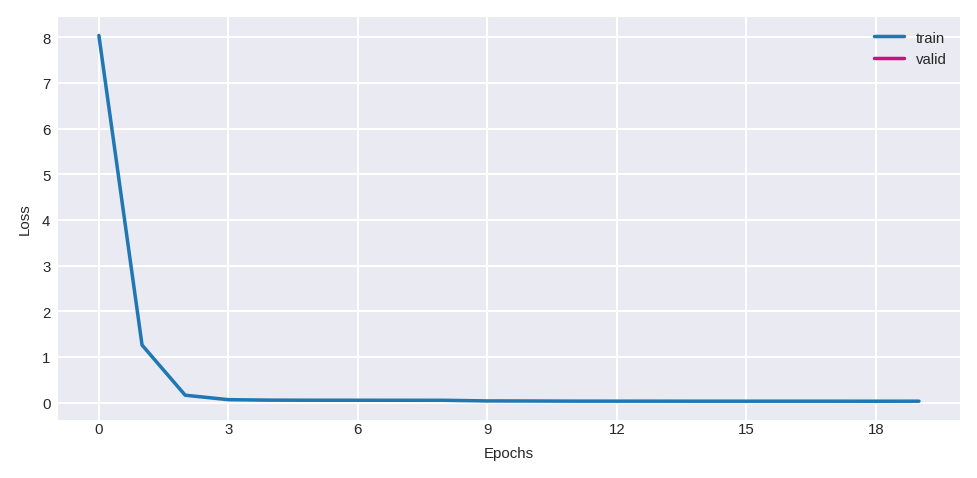

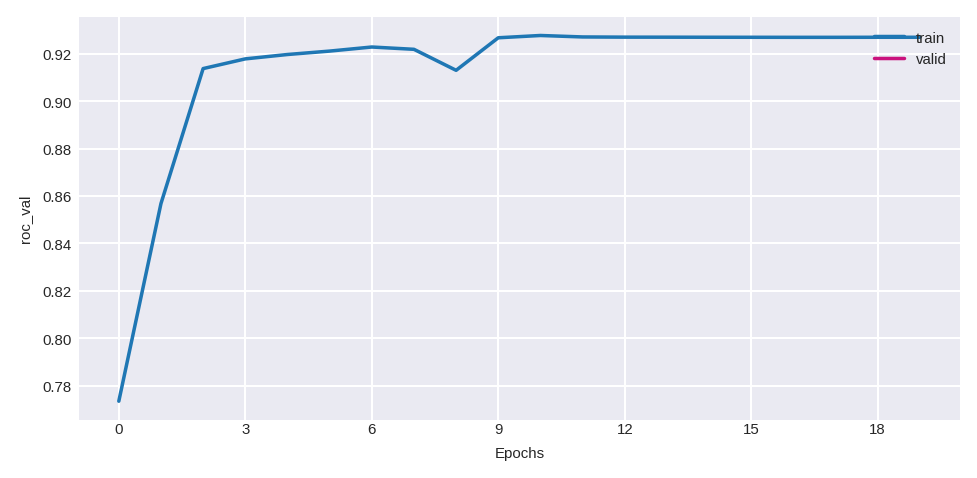

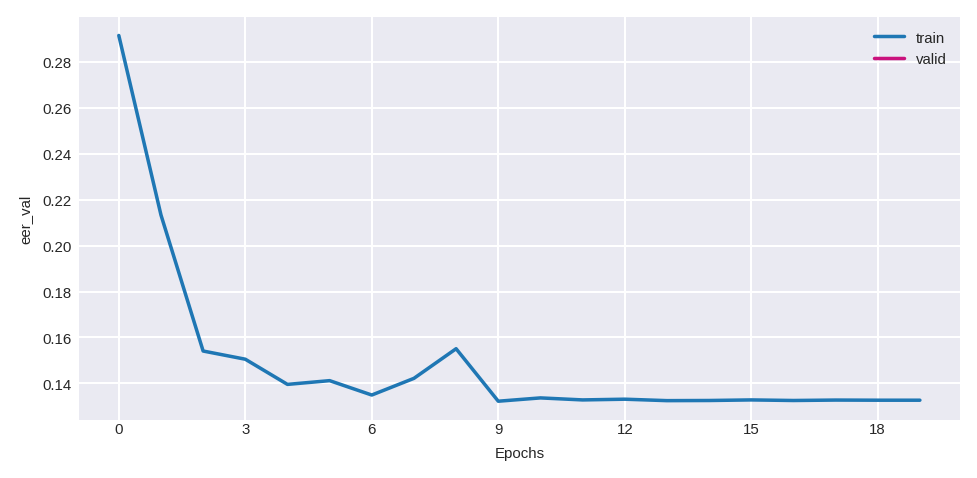

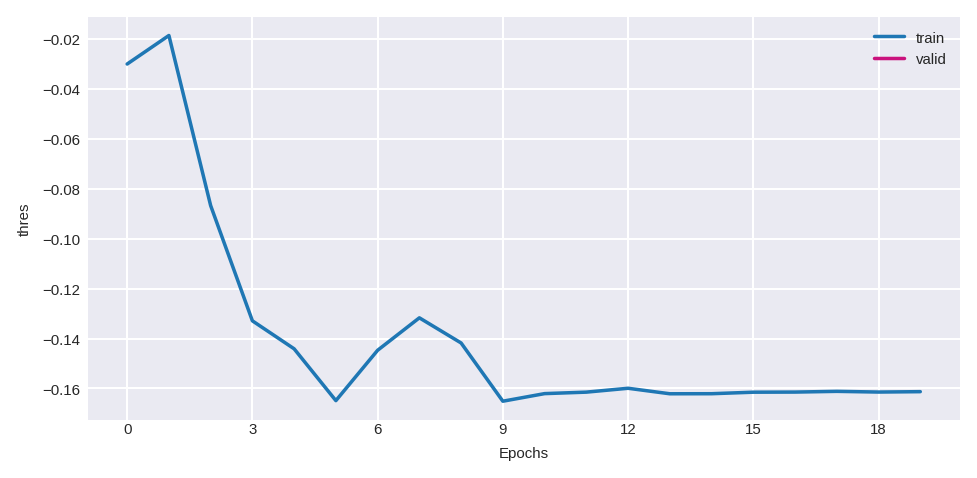

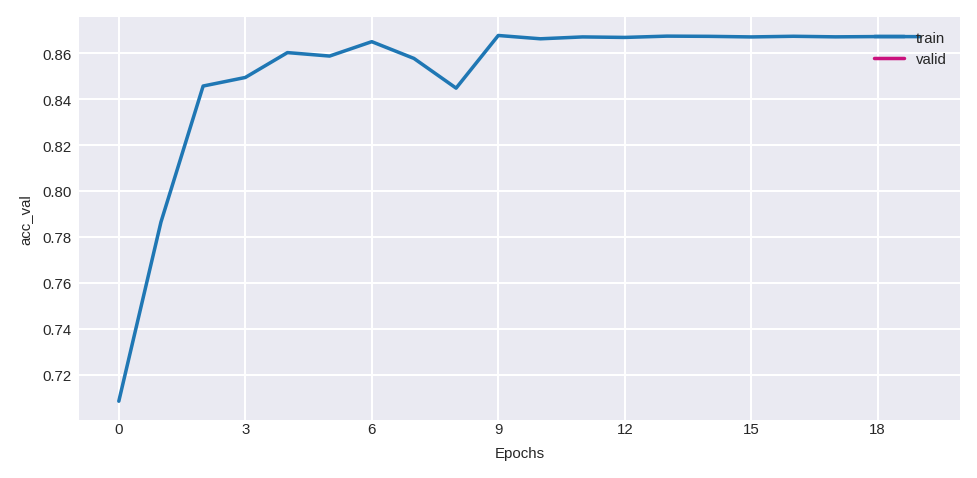

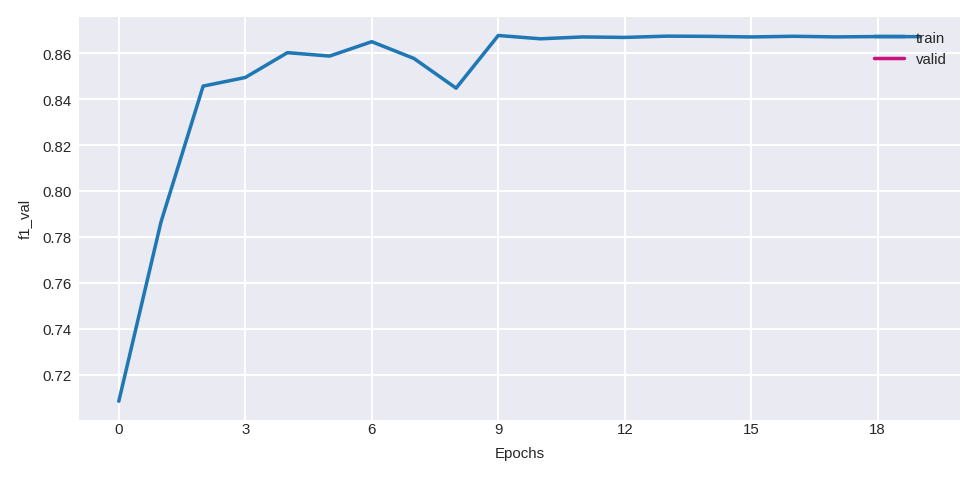

In [28]:
print(f"train_set: {train_set+[47]}")
print(f"test_set: {test_set}")
P.smoothing = None

preprocessing_method=None
time_of_execution = time.strftime("%Y/%m/%d-%H:%M:%S")


init_experiment_params(exp_config=P)



for clf_type in tqdm(["OCSVM"]):#since no preprocessing, all this shoud be identical for all of the classifiers


    dfList_dict={
                "dfList_exp1": raw_dfList_exp1,
                "dfList_exp2": raw_dfList_exp2,
                "dfList_exp1_user_47": raw_dfList_exp1_user_47,
                "dfList_exp2_user_47": raw_dfList_exp2_user_47
    }
    
    save_info_dict={"model_classifier_type": f"SCNN-{clf_type}", "exp_num": EXP_NUM_0}
    model_training_with_training_config_dict(dfList_dict=dfList_dict, window_size_lst=WINDOW_SIZE_LST, train_set=train_set, exp_config=P, overlap=OVERLAP, 
                                             training_config_dict=TRAINING_CONFIG_DICT, save_info_dict=save_info_dict)

# 1. Butterworth frequency Cut-off

## 1.1 Naive Approach
### Optimizing and Testing

In [ ]:
init_experiment_params(exp_config=P)

print(f"train_set: {train_set+[47]}")
print(f"test_set: {test_set}")
P.smoothing = "Butterworth"

preprocessing_method="Naive"
time_of_execution = time.strftime("%Y/%m/%d-%H:%M:%S")





for clf_type in tqdm(CLASSIFIER_TYPE_LST):
    
    rival_test_hyperparameters_file_name=f"{FINAL_EXP_RESULTS_PATH}/WACA-{clf_type}/{P.smoothing}_Mean_EER_{preprocessing_method}_df_test_dict_raw_df.json"
    rival_test_hyperparameters_df = pd.read_json(rival_test_hyperparameters_file_name)
    
    P.cut_off_freq=rival_test_hyperparameters_df["cut_off_freq"][0]
    print(f"cut_off_freq: {P.cut_off_freq}")

    ffted_dfList_exp1 = get_ffted_dfList(raw_dfList_exp1, cut_off_freq=P.cut_off_freq, filter_order=P.filter_order, sampling_freq=P.sampling_freq, filtfilt=P.filtfilt)
    ffted_dfList_exp2 = get_ffted_dfList(raw_dfList_exp2, cut_off_freq=P.cut_off_freq, filter_order=P.filter_order, sampling_freq=P.sampling_freq, filtfilt=P.filtfilt)

    ffted_dfList_exp1_user_47 = get_ffted_dfList(raw_dfList_exp1_user_47, cut_off_freq=P.cut_off_freq, filter_order=P.filter_order, sampling_freq=P.sampling_freq, filtfilt=P.filtfilt)
    ffted_dfList_exp2_user_47 = get_ffted_dfList(raw_dfList_exp2_user_47, cut_off_freq=P.cut_off_freq, filter_order=P.filter_order, sampling_freq=P.sampling_freq, filtfilt=P.filtfilt)


    dfList_dict={
                "dfList_exp1": ffted_dfList_exp1,
                "dfList_exp2": ffted_dfList_exp2,
                "dfList_exp1_user_47": ffted_dfList_exp1_user_47,
                "dfList_exp2_user_47": ffted_dfList_exp2_user_47
    }
    
    save_info_dict={"model_classifier_type": f"SCNN-{clf_type}", "exp_num": EXP_NUM_1_1}
    model_training_with_training_config_dict(dfList_dict=dfList_dict, window_size_lst=WINDOW_SIZE_LST, train_set=train_set, exp_config=P, overlap=OVERLAP, 
                                             training_config_dict=TRAINING_CONFIG_DICT, save_info_dict=save_info_dict)

In [23]:
WINDOW_SIZE_LST

[1000]

## 1.2 Realworld Approach (per unknown window application of filter)
### Optimizing and Testing

In [ ]:
init_experiment_params(exp_config=P)

P.smoothing = "Butterworth"

preprocessing_method="Realworld-per_unknown_window"

clf_type="standalone"


time_of_execution = time.strftime("%Y/%m/%d-%H:%M:%S")
    




P.Butter_per_win_argdict={
    "filter_order": P.filter_order,
    "cut_off_freq": None,
    "sampling_freq": P.sampling_freq,
    "filtfilt": P.filtfilt,
    }



for cv_fold_idx in range(len(THREE_FOLD_CV)):

    train_set, test_set=THREE_FOLD_CV[cv_fold_idx]
    print(f"train_set: {train_set}")
    print(f"test_set: {test_set}")
    
    #--------------butter33----------------------
    P.cut_off_freq=33

    P.Butter_per_win_argdict={
        "filter_order": P.filter_order,
        "cut_off_freq": P.cut_off_freq,
        "sampling_freq": P.sampling_freq,
        "filtfilt": P.filtfilt,
        }   


    print(f"cut_off_freq: {P.cut_off_freq}")

    ffted_dfList_exp2 = get_ffted_dfList(raw_dfList_exp2, cut_off_freq=P.cut_off_freq, filter_order=P.filter_order, sampling_freq=P.sampling_freq, filtfilt=P.filtfilt)

    if 29 in train_set:
        ffted_dfList_exp2_user_47 = get_ffted_dfList(raw_dfList_exp2_user_47, cut_off_freq=P.cut_off_freq, filter_order=P.filter_order, sampling_freq=P.sampling_freq, filtfilt=P.filtfilt)


    #--------------butter33----------------------

    dfList_dict={
                "dfList_exp1": raw_dfList_exp1,
                "dfList_exp2": ffted_dfList_exp2,
    }

    if 29 in train_set:
        dfList_dict["dfList_exp1_user_47"] = raw_dfList_exp1_user_47
        dfList_dict["dfList_exp2_user_47"] = ffted_dfList_exp2_user_47

    save_info_dict={"model_classifier_type": f"SCNN-{clf_type}", "exp_num": EXP_NUM_1_2, "cv_fold_idx": cv_fold_idx}
    model_training_with_training_config_dict(dfList_dict=dfList_dict, window_size_lst=WINDOW_SIZE_LST, train_set=train_set, exp_config=P, overlap=OVERLAP, 
                                             training_config_dict=get_training_config_dict('Butter', cv_fold_idx), save_info_dict=save_info_dict)

reseting experiment params successful!
train_set: {0, 1, 2, 3, 4, 5, 6, 9, 10, 12, 14, 15, 16, 18, 19, 22, 23, 24, 25, 28}
test_set: {7, 8, 11, 13, 17, 20, 21, 26, 27, 29}
cut_off_freq: 33


  0%|          | 0/5 [00:00<?, ?it/s]

Seed was set to: 567
len(exp1_df_user_set_dict): 20
len(exp2_df_user_set_dict): 20
674
0.0026352922012168813



100%|██████████| 20/20 [29:45<00:00, 89.30s/it]


Training samples:   47880, shape: (47880, 125, 6), class balance: (array([0., 1.], dtype=float32), array([23940, 23940]))



  0%|          | 0/4 [00:00<?, ?it/s]

SCNN_3_1_conv_1_dense_arg_dict_default
loss_record_dict: [10.073803901672363, 5.2316508293151855, 2.340040922164917, 0.8859003186225891, 0.3108319342136383, 0.15190371870994568, 0.09389187395572662, 0.07091760635375977, 0.06357927620410919, 0.0586966946721077, 0.05836208164691925, 0.05583347752690315, 0.05745114013552666, 0.06016924977302551, 0.04976790025830269, 0.04962199553847313, 0.04936247318983078, 0.05050818994641304, 0.04984334483742714, 0.04723537713289261, 0.04707246646285057, 0.04699854552745819, 0.04694194719195366, 0.046913646161556244, 0.04711378365755081, 0.04651818796992302, 0.046422623097896576, 0.046488068997859955, 0.046345584094524384, 0.04634251445531845, 0.046352043747901917, 0.04632658138871193], min_val_index: 31
{0: 0.001, 1: 0.001, 2: 0.001, 3: 0.001, 4: 0.001, 5: 0.001, 6: 0.001, 7: 0.001, 8: 0.001, 9: 0.001, 10: 0.001, 11: 0.001, 12: 0.001, 13: 0.001, 14: 0.00020000001, 15: 0.00020000001, 16: 0.00020000001, 17: 0.00020000001, 18: 0.00020000001, 19: 4.0000003

2023-07-31 08:54:57.686713: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-07-31 08:54:58.425999: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1510] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 43490 MB memory:  -> device: 0, name: NVIDIA A40, pci bus id: 0000:ca:00.0, compute capability: 8.6


================================[ Initial State ]================================

2023-07-31 08:55:00.917931: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)
2023-07-31 08:55:01.908982: I tensorflow/stream_executor/cuda/cuda_dnn.cc:369] Loaded cuDNN version 8101
2023-07-31 08:55:02.731205: I tensorflow/core/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory
2023-07-31 08:55:02.732725: I tensorflow/core/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory
2023-07-31 08:55:02.732744: W tensorflow/stream_executor/gpu/asm_compiler.cc:77] Couldn't get ptxas version string: Internal: Couldn't invoke ptxas --version
2023-07-31 08:55:02.734182: I tensorflow/core/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory
2023-07-31 08:55:02.734252: W tensorflow/stream_executor/gpu/redzone_allocator.cc:314] Internal: Failed to launch ptxas
Relying on driver to perform ptx co


TRAIN: roc_auc: 0.7333, eer: 0.3269, thres: 0.1626 => acc: 0.6732, f1: 0.6732

Epoch 1/32
188/188 [==============================] - 6s 14ms/step - loss: 14.3311
Epoch 2/32
188/188 [==============================] - 3s 15ms/step - loss: 4.5850
Epoch 3/32
188/188 [==============================] - 3s 17ms/step - loss: 0.8699
Epoch 4/32
188/188 [==============================] - 4s 24ms/step - loss: 0.1504
Epoch 5/32
188/188 [==============================] - 5s 25ms/step - loss: 0.0808
Epoch 6/32
188/188 [==============================] - 4s 23ms/step - loss: 0.0670
Epoch 7/32
188/188 [==============================] - 3s 15ms/step - loss: 0.0639
Epoch 8/32
188/188 [==============================] - 4s 20ms/step - loss: 0.0638
Epoch 9/32
188/188 [==============================] - 3s 14ms/step - loss: 0.0641
Epoch 10/32
188/188 [==============================] - 3s 14ms/step - loss: 0.0645
Epoch 11/32
188/188 [==============================] - 3s 17ms/step - loss: 0.0650
Epoch 12/32
188

2023-07-31 08:59:16.555842: W tensorflow/python/util/util.cc:348] Sets are not currently considered sequences, but this may change in the future, so consider avoiding using them.


INFO:tensorflow:Assets written to: clip=False_experiments_results/SCNN_trained_models/SCNN-standalone/1.2/SCNN_3_1_conv_1_dense_arg_dict_default/125/SCNN-standalone-1.2-SCNN_3_1_conv_1_dense_arg_dict_default-125-model-Butter33-cv0/assets
INFO:tensorflow:Assets written to: clip=False_experiments_results/SCNN_trained_models/SCNN-standalone/1.2/SCNN_3_1_conv_1_dense_arg_dict_default/125/SCNN-standalone-1.2-SCNN_3_1_conv_1_dense_arg_dict_default-125-deep_feature_extractor-Butter33-cv0/assets
saved model at clip=False_experiments_results/SCNN_trained_models/SCNN-standalone/1.2/SCNN_3_1_conv_1_dense_arg_dict_default/125



 25%|██▌       | 1/4 [04:28<13:24, 268.18s/it]

SCNN_3_2_conv_1_dense_arg_dict_default
loss_record_dict: [15.716132164001465, 9.899250984191895, 5.343303680419922, 2.6842458248138428, 1.2409600019454956, 0.5659531950950623, 0.29382699728012085, 0.18657009303569794, 0.13462430238723755, 0.10718023777008057, 0.08937742561101913, 0.07547582685947418, 0.070892333984375, 0.06863418221473694, 0.06522392481565475, 0.06333685666322708, 0.06662758439779282, 0.06328468769788742, 0.05253357067704201, 0.05288194864988327, 0.05213325470685959, 0.05155077949166298, 0.0519898496568203, 0.052066631615161896, 0.04897097498178482, 0.04879341274499893, 0.04883032664656639, 0.048672936856746674, 0.04837457090616226, 0.048685215413570404, 0.04855845868587494, 0.04819939658045769, 0.048214737325906754, 0.04819599539041519, 0.04810255393385887, 0.048100072890520096, 0.04808347672224045], min_val_index: 36
{0: 0.001, 1: 0.001, 2: 0.001, 3: 0.001, 4: 0.001, 5: 0.001, 6: 0.001, 7: 0.001, 8: 0.001, 9: 0.001, 10: 0.001, 11: 0.001, 12: 0.001, 13: 0.001, 14: 0.0


 50%|█████     | 2/4 [12:58<13:41, 410.69s/it]

SCNN_1_3_conv_1_dense_arg_dict_default
loss_record_dict: [18.328460693359375, 9.475564002990723, 4.6607985496521, 2.420276403427124, 1.0804342031478882, 0.5269112586975098, 0.3031426668167114, 0.19381529092788696, 0.14058607816696167, 0.11111706495285034, 0.0949573740363121, 0.08494645357131958, 0.08636436611413956, 0.08337599784135818, 0.08082424104213715, 0.08084236830472946, 0.08617961406707764, 0.06251432001590729, 0.06140502169728279, 0.06258787214756012, 0.06023702770471573, 0.06241462007164955, 0.06306242942810059, 0.05636637285351753, 0.056337662041187286, 0.05650179460644722, 0.055344391614198685, 0.055377986282110214, 0.055225420743227005, 0.05538150668144226, 0.055304836481809616, 0.05505130812525749, 0.05508407950401306, 0.05510381609201431, 0.05512810871005058], min_val_index: 31
{0: 0.001, 1: 0.001, 2: 0.001, 3: 0.001, 4: 0.001, 5: 0.001, 6: 0.001, 7: 0.001, 8: 0.001, 9: 0.001, 10: 0.001, 11: 0.001, 12: 0.001, 13: 0.001, 14: 0.001, 15: 0.001, 16: 0.001, 17: 0.00020000001,


 75%|███████▌  | 3/4 [20:29<07:08, 428.87s/it]

SCNN_3_123_conv_1_dense_arg_dict_default
loss_record_dict: [16.1472225189209, 9.74377155303955, 5.355837345123291, 2.660916566848755, 1.2759547233581543, 0.5929648280143738, 0.3076417148113251, 0.16896609961986542, 0.11618366092443466, 0.09114176779985428, 0.0780472382903099, 0.06940588355064392, 0.06748833507299423, 0.06541101634502411, 0.0631309375166893, 0.06268526613712311, 0.0656065046787262, 0.06300485134124756, 0.05234910547733307, 0.05240039899945259, 0.05306578055024147, 0.04979795962572098, 0.049649421125650406, 0.04983283206820488, 0.04987134411931038, 0.04921209067106247, 0.04923289269208908, 0.04931460693478584, 0.04918484762310982, 0.04918787255883217, 0.04918588697910309], min_val_index: 28
{0: 0.001, 1: 0.001, 2: 0.001, 3: 0.001, 4: 0.001, 5: 0.001, 6: 0.001, 7: 0.001, 8: 0.001, 9: 0.001, 10: 0.001, 11: 0.001, 12: 0.001, 13: 0.001, 14: 0.001, 15: 0.001, 16: 0.001, 17: 0.001, 18: 0.00020000001, 19: 0.00020000001, 20: 0.00020000001, 21: 4.0000003e-05, 22: 4.0000003e-05, 2

/tmp/ipykernel_366750/2807832909.py:120: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig = plt.figure(figsize=(5.473, 2.7), dpi=180)


saved model at clip=False_experiments_results/SCNN_trained_models/SCNN-standalone/1.2/SCNN_3_123_conv_1_dense_arg_dict_default/125



 20%|██        | 1/5 [1:03:42<4:14:51, 3822.99s/it]

Seed was set to: 567
len(exp1_df_user_set_dict): 20
len(exp2_df_user_set_dict): 20
334
0.010731381548280685



100%|██████████| 20/20 [14:47<00:00, 44.39s/it]


Training samples:   47880, shape: (47880, 250, 6), class balance: (array([0., 1.], dtype=float32), array([23940, 23940]))



  0%|          | 0/4 [00:00<?, ?it/s]

SCNN_3_1_conv_1_dense_arg_dict_default
loss_record_dict: [8.022610664367676, 3.071751356124878, 1.1376173496246338, 0.4135195016860962, 0.16315872967243195, 0.08441072702407837, 0.05863469839096069, 0.05145920813083649, 0.047359660267829895, 0.04826939478516579, 0.048261936753988266, 0.03763797506690025, 0.03678135201334953, 0.036961156874895096, 0.03783790022134781, 0.034587495028972626, 0.03434363007545471, 0.03453003987669945, 0.03442705422639847, 0.033813998103141785, 0.03379299119114876, 0.03383506461977959, 0.03372379392385483, 0.03370225802063942, 0.03370136767625809, 0.03369686007499695, 0.03366869315505028], min_val_index: 26
{0: 0.001, 1: 0.001, 2: 0.001, 3: 0.001, 4: 0.001, 5: 0.001, 6: 0.001, 7: 0.001, 8: 0.001, 9: 0.001, 10: 0.001, 11: 0.00020000001, 12: 0.00020000001, 13: 0.00020000001, 14: 0.00020000001, 15: 4.0000003e-05, 16: 4.0000003e-05, 17: 4.0000003e-05, 18: 4.0000003e-05, 19: 8.000001e-06, 20: 8.000001e-06, 21: 8.000001e-06, 22: 1.6000001e-06, 23: 1.6000001e-06, 2


 25%|██▌       | 1/4 [10:01<30:05, 601.91s/it]

SCNN_3_2_conv_1_dense_arg_dict_default
loss_record_dict: [13.719284057617188, 7.237940311431885, 3.346856117248535, 1.5439828634262085, 0.6847800016403198, 0.3057108223438263, 0.1746453046798706, 0.12279069423675537, 0.0895361453294754, 0.07780041545629501, 0.07267268747091293, 0.05666689574718475, 0.055938560515642166, 0.05991484597325325, 0.05289963632822037, 0.055638331919908524, 0.053555458784103394, 0.04278402030467987, 0.04338499531149864, 0.04304652288556099, 0.039535269141197205, 0.03974034637212753, 0.040067508816719055, 0.03928963840007782, 0.039232540875673294, 0.03927629068493843, 0.039157379418611526, 0.03916643187403679, 0.03916396200656891, 0.0391770638525486], min_val_index: 26
{0: 0.001, 1: 0.001, 2: 0.001, 3: 0.001, 4: 0.001, 5: 0.001, 6: 0.001, 7: 0.001, 8: 0.001, 9: 0.001, 10: 0.001, 11: 0.001, 12: 0.001, 13: 0.001, 14: 0.001, 15: 0.001, 16: 0.001, 17: 0.00020000001, 18: 0.00020000001, 19: 0.00020000001, 20: 4.0000003e-05, 21: 4.0000003e-05, 22: 4.0000003e-05, 23: 8


 50%|█████     | 2/4 [25:03<25:56, 778.38s/it]

SCNN_1_3_conv_1_dense_arg_dict_default
loss_record_dict: [16.06092643737793, 7.002536296844482, 3.1336047649383545, 1.406762719154358, 0.6427517533302307, 0.28691548109054565, 0.1850229650735855, 0.10975118726491928, 0.09452447295188904, 0.08719901740550995, 0.08782390505075455, 0.08683504909276962, 0.0828746110200882, 0.08706428110599518, 0.08141083270311356, 0.08585070073604584, 0.08860708028078079, 0.06422331184148788, 0.06361318379640579, 0.06267119199037552, 0.06137562915682793, 0.06350789219141006, 0.06282760202884674, 0.057017065584659576, 0.057179346680641174, 0.057129815220832825, 0.0553491935133934, 0.055215541273355484, 0.055321160703897476, 0.055206216871738434, 0.05497457832098007, 0.0549384281039238, 0.05496808886528015, 0.05492394417524338], min_val_index: 33
{0: 0.001, 1: 0.001, 2: 0.001, 3: 0.001, 4: 0.001, 5: 0.001, 6: 0.001, 7: 0.001, 8: 0.001, 9: 0.001, 10: 0.001, 11: 0.001, 12: 0.001, 13: 0.001, 14: 0.001, 15: 0.001, 16: 0.001, 17: 0.00020000001, 18: 0.00020000001,


 75%|███████▌  | 3/4 [34:59<11:35, 695.14s/it]

SCNN_3_123_conv_1_dense_arg_dict_default
loss_record_dict: [13.988040924072266, 7.167835235595703, 3.2759127616882324, 1.4874988794326782, 0.6409854888916016, 0.29229143261909485, 0.13132067024707794, 0.08417432755231857, 0.06424303352832794, 0.057548888027668, 0.05355967953801155, 0.05006033554673195, 0.04834410920739174, 0.05006209388375282, 0.05023769289255142, 0.03921893984079361, 0.03891368955373764, 0.039318036288022995, 0.03906025364995003, 0.03607013449072838, 0.03611939027905464, 0.03612614423036575, 0.03546610847115517, 0.035406891256570816, 0.03542597219347954, 0.03529585152864456, 0.03529006242752075, 0.03530026599764824, 0.035295214504003525], min_val_index: 26
{0: 0.001, 1: 0.001, 2: 0.001, 3: 0.001, 4: 0.001, 5: 0.001, 6: 0.001, 7: 0.001, 8: 0.001, 9: 0.001, 10: 0.001, 11: 0.001, 12: 0.001, 13: 0.001, 14: 0.001, 15: 0.00020000001, 16: 0.00020000001, 17: 0.00020000001, 18: 0.00020000001, 19: 4.0000003e-05, 20: 4.0000003e-05, 21: 4.0000003e-05, 22: 8.000001e-06, 23: 8.0000


 40%|████      | 2/5 [2:06:50<3:10:05, 3801.94s/it]

Seed was set to: 567
len(exp1_df_user_set_dict): 20
len(exp2_df_user_set_dict): 20
166
0.0434442589635651



100%|██████████| 20/20 [04:42<00:00, 14.10s/it]


Training samples:   47880, shape: (47880, 500, 6), class balance: (array([0., 1.], dtype=float32), array([23940, 23940]))



  0%|          | 0/4 [00:00<?, ?it/s]

SCNN_3_1_conv_1_dense_arg_dict_default
loss_record_dict: [6.522996425628662, 1.897423267364502, 0.6083194613456726, 0.21401113271713257, 0.08813171088695526, 0.05403505265712738, 0.04320436716079712, 0.04149061068892479, 0.041574325412511826, 0.042647454887628555, 0.03128844127058983, 0.0310265701264143, 0.030802782624959946, 0.030683083459734917, 0.0320977084338665, 0.03108850307762623, 0.028071163222193718, 0.02812749333679676, 0.028341423720121384, 0.02769225463271141, 0.027663325890898705, 0.027668435126543045, 0.027537047863006592, 0.027512487024068832, 0.027512574568390846, 0.027499791234731674], min_val_index: 25
{0: 0.001, 1: 0.001, 2: 0.001, 3: 0.001, 4: 0.001, 5: 0.001, 6: 0.001, 7: 0.001, 8: 0.001, 9: 0.001, 10: 0.00020000001, 11: 0.00020000001, 12: 0.00020000001, 13: 0.00020000001, 14: 0.00020000001, 15: 0.00020000001, 16: 4.0000003e-05, 17: 4.0000003e-05, 18: 4.0000003e-05, 19: 8.000001e-06, 20: 8.000001e-06, 21: 8.000001e-06, 22: 1.6000001e-06, 23: 1.6000001e-06, 24: 1.60


 25%|██▌       | 1/4 [07:16<21:48, 436.21s/it]

SCNN_3_2_conv_1_dense_arg_dict_default
loss_record_dict: [12.212442398071289, 5.536579132080078, 2.244662046432495, 0.942560076713562, 0.4173784554004669, 0.18713660538196564, 0.10436266660690308, 0.0778433158993721, 0.06637708842754364, 0.05903482809662819, 0.05383395403623581, 0.0487741082906723, 0.04718055948615074, 0.04605387896299362, 0.047315921634435654, 0.047296226024627686, 0.03571662679314613, 0.036054641008377075, 0.03547251224517822, 0.03566674143075943, 0.03601919859647751, 0.03336884081363678, 0.03304728865623474, 0.03289983794093132, 0.033115454018116, 0.03312930837273598, 0.03245588392019272, 0.032405320554971695, 0.032405197620391846, 0.03230785205960274, 0.03230300545692444, 0.03227722644805908, 0.03226785734295845], min_val_index: 32
{0: 0.001, 1: 0.001, 2: 0.001, 3: 0.001, 4: 0.001, 5: 0.001, 6: 0.001, 7: 0.001, 8: 0.001, 9: 0.001, 10: 0.001, 11: 0.001, 12: 0.001, 13: 0.001, 14: 0.001, 15: 0.001, 16: 0.00020000001, 17: 0.00020000001, 18: 0.00020000001, 19: 0.0002000


 50%|█████     | 2/4 [17:56<18:32, 556.21s/it]

SCNN_1_3_conv_1_dense_arg_dict_default
loss_record_dict: [14.20686149597168, 5.529148578643799, 2.3002519607543945, 0.8938254117965698, 0.4981096684932709, 0.20136632025241852, 0.11165162175893784, 0.08806181699037552, 0.07822272926568985, 0.07249151915311813, 0.07732770591974258, 0.06847857683897018, 0.06070418655872345, 0.06889031827449799, 0.0684426873922348, 0.042322639375925064, 0.04132924601435661, 0.04248948022723198, 0.04137787967920303, 0.03564678877592087, 0.035448815673589706, 0.03527221083641052, 0.035246506333351135, 0.0353427417576313, 0.03398609161376953, 0.03410826623439789, 0.03411736339330673, 0.03383992612361908, 0.03380243107676506, 0.03378980606794357, 0.03376542031764984], min_val_index: 30
{0: 0.001, 1: 0.001, 2: 0.001, 3: 0.001, 4: 0.001, 5: 0.001, 6: 0.001, 7: 0.001, 8: 0.001, 9: 0.001, 10: 0.001, 11: 0.001, 12: 0.001, 13: 0.001, 14: 0.001, 15: 0.00020000001, 16: 0.00020000001, 17: 0.00020000001, 18: 0.00020000001, 19: 4.0000003e-05, 20: 4.0000003e-05, 21: 4.00


 75%|███████▌  | 3/4 [25:05<08:18, 498.06s/it]

SCNN_3_123_conv_1_dense_arg_dict_default
loss_record_dict: [12.237417221069336, 5.252593994140625, 1.9715373516082764, 0.7905675172805786, 0.3242676258087158, 0.14129526913166046, 0.0815659686923027, 0.05920259281992912, 0.050309326499700546, 0.045530419796705246, 0.044200193136930466, 0.04436562582850456, 0.04220588132739067, 0.04330926388502121, 0.044167980551719666, 0.030524618923664093, 0.030082153156399727, 0.030481694266200066, 0.030285866931080818, 0.02696080319583416, 0.026776444166898727, 0.026860615238547325, 0.027058715000748634, 0.02624491974711418, 0.02619597315788269, 0.026226386427879333, 0.026070095598697662, 0.02605230174958706, 0.026057086884975433, 0.026052044704556465], min_val_index: 29
{0: 0.001, 1: 0.001, 2: 0.001, 3: 0.001, 4: 0.001, 5: 0.001, 6: 0.001, 7: 0.001, 8: 0.001, 9: 0.001, 10: 0.001, 11: 0.001, 12: 0.001, 13: 0.001, 14: 0.001, 15: 0.00020000001, 16: 0.00020000001, 17: 0.00020000001, 18: 0.00020000001, 19: 4.0000003e-05, 20: 4.0000003e-05, 21: 4.0000003


 60%|██████    | 3/5 [2:48:54<1:47:17, 3218.54s/it]

Seed was set to: 567
len(exp1_df_user_set_dict): 20
len(exp2_df_user_set_dict): 20
110
0.09893801652892562



100%|██████████| 20/20 [03:11<00:00,  9.60s/it]


Training samples:   47880, shape: (47880, 750, 6), class balance: (array([0., 1.], dtype=float32), array([23940, 23940]))



  0%|          | 0/4 [00:00<?, ?it/s]

SCNN_3_1_conv_1_dense_arg_dict_default
loss_record_dict: [5.568518161773682, 1.372458577156067, 0.4098225235939026, 0.14075562357902527, 0.06305095553398132, 0.0443081296980381, 0.040305860340595245, 0.04131244122982025, 0.042006466537714005, 0.028693975880742073, 0.028188861906528473, 0.02849411778151989, 0.028883986175060272, 0.025118976831436157, 0.02526514232158661, 0.025275520980358124, 0.024565979838371277, 0.02454095520079136, 0.024572478607296944, 0.024425916373729706, 0.024438466876745224, 0.02445361390709877, 0.02444472908973694], min_val_index: 19
{0: 0.001, 1: 0.001, 2: 0.001, 3: 0.001, 4: 0.001, 5: 0.001, 6: 0.001, 7: 0.001, 8: 0.001, 9: 0.00020000001, 10: 0.00020000001, 11: 0.00020000001, 12: 0.00020000001, 13: 4.0000003e-05, 14: 4.0000003e-05, 15: 4.0000003e-05, 16: 8.000001e-06, 17: 8.000001e-06, 18: 8.000001e-06, 19: 1.6000001e-06, 20: 1.6000001e-06, 21: 1.6000001e-06, 22: 1e-06}
{'loss': [11.47111988067627, 3.48923921585083, 0.874386727809906, 0.2583114802837372, 0.10


 25%|██▌       | 1/4 [08:08<24:26, 488.95s/it]

SCNN_3_2_conv_1_dense_arg_dict_default
loss_record_dict: [11.595978736877441, 4.97177267074585, 1.9453920125961304, 0.8069358468055725, 0.3613681495189667, 0.1789848506450653, 0.1006772518157959, 0.06858660280704498, 0.054817456752061844, 0.046147897839546204, 0.04438421502709389, 0.04215136542916298, 0.03927742689847946, 0.0416056364774704, 0.04243731498718262, 0.027911759912967682, 0.02728237211704254, 0.027718383818864822, 0.027376538142561913, 0.023809008300304413, 0.02407022938132286, 0.023729268461465836, 0.023299163207411766, 0.023258542641997337, 0.023247044533491135, 0.02316739782691002, 0.023178042843937874, 0.023188168182969093, 0.02317860908806324], min_val_index: 25
{0: 0.001, 1: 0.001, 2: 0.001, 3: 0.001, 4: 0.001, 5: 0.001, 6: 0.001, 7: 0.001, 8: 0.001, 9: 0.001, 10: 0.001, 11: 0.001, 12: 0.001, 13: 0.001, 14: 0.001, 15: 0.00020000001, 16: 0.00020000001, 17: 0.00020000001, 18: 0.00020000001, 19: 4.0000003e-05, 20: 4.0000003e-05, 21: 4.0000003e-05, 22: 8.000001e-06, 23: 8


 50%|█████     | 2/4 [17:23<17:34, 527.46s/it]

SCNN_1_3_conv_1_dense_arg_dict_default
loss_record_dict: [13.20151138305664, 4.769459247589111, 1.8550313711166382, 0.8648294806480408, 0.3604327142238617, 0.1665297895669937, 0.09124862402677536, 0.07393977046012878, 0.07017211616039276, 0.07412126660346985, 0.06559789925813675, 0.06662802398204803, 0.07535384595394135, 0.040893953293561935, 0.04120684787631035, 0.04209008067846298, 0.034264687448740005, 0.03442883864045143, 0.03463733196258545, 0.033163852989673615, 0.03306930884718895, 0.03310902416706085, 0.03279227018356323, 0.032783932983875275, 0.032799169421195984, 0.03276439011096954], min_val_index: 25
{0: 0.001, 1: 0.001, 2: 0.001, 3: 0.001, 4: 0.001, 5: 0.001, 6: 0.001, 7: 0.001, 8: 0.001, 9: 0.001, 10: 0.001, 11: 0.001, 12: 0.001, 13: 0.00020000001, 14: 0.00020000001, 15: 0.00020000001, 16: 4.0000003e-05, 17: 4.0000003e-05, 18: 4.0000003e-05, 19: 8.000001e-06, 20: 8.000001e-06, 21: 8.000001e-06, 22: 1.6000001e-06, 23: 1.6000001e-06, 24: 1.6000001e-06, 25: 1e-06}
{'loss': [


 75%|███████▌  | 3/4 [26:26<08:54, 534.75s/it]

SCNN_3_123_conv_1_dense_arg_dict_default
loss_record_dict: [11.084163665771484, 4.205053806304932, 1.4511260986328125, 0.5593744516372681, 0.21604551374912262, 0.09728997200727463, 0.06465490907430649, 0.049508340656757355, 0.04518885537981987, 0.042302753776311874, 0.0427081435918808, 0.042227812111377716, 0.028915459290146828, 0.028574325144290924, 0.029553188011050224, 0.028994135558605194, 0.02530892938375473, 0.025287477299571037, 0.025379937142133713, 0.02463378943502903, 0.024632450193166733, 0.024632908403873444, 0.024509761482477188, 0.024500751867890358, 0.024515831843018532, 0.024486787617206573], min_val_index: 25
{0: 0.001, 1: 0.001, 2: 0.001, 3: 0.001, 4: 0.001, 5: 0.001, 6: 0.001, 7: 0.001, 8: 0.001, 9: 0.001, 10: 0.001, 11: 0.001, 12: 0.00020000001, 13: 0.00020000001, 14: 0.00020000001, 15: 0.00020000001, 16: 4.0000003e-05, 17: 4.0000003e-05, 18: 4.0000003e-05, 19: 8.000001e-06, 20: 8.000001e-06, 21: 8.000001e-06, 22: 1.6000001e-06, 23: 1.6000001e-06, 24: 1.6000001e-06,


 80%|████████  | 4/5 [3:29:34<48:31, 2911.00s/it]  

Seed was set to: 567
len(exp1_df_user_set_dict): 20
len(exp2_df_user_set_dict): 20
82
0.17804134443783462



100%|██████████| 20/20 [02:14<00:00,  6.72s/it]


Training samples:   47880, shape: (47880, 1000, 6), class balance: (array([0., 1.], dtype=float32), array([23940, 23940]))



  0%|          | 0/4 [00:00<?, ?it/s]

SCNN_3_1_conv_1_dense_arg_dict_default
loss_record_dict: [5.2903900146484375, 1.2590899467468262, 0.3746944069862366, 0.1274586319923401, 0.05892447009682655, 0.04271266981959343, 0.03856337070465088, 0.03740024194121361, 0.03970513492822647, 0.038411788642406464, 0.025734078139066696, 0.025485815480351448, 0.025581559166312218, 0.025991136208176613, 0.02256559580564499, 0.022411642596125603, 0.02233884297311306, 0.02262875624001026, 0.02182639203965664, 0.021810004487633705, 0.02184484340250492, 0.021703585982322693, 0.02170710265636444, 0.021698784083127975, 0.02167651429772377], min_val_index: 24
{0: 0.001, 1: 0.001, 2: 0.001, 3: 0.001, 4: 0.001, 5: 0.001, 6: 0.001, 7: 0.001, 8: 0.001, 9: 0.001, 10: 0.00020000001, 11: 0.00020000001, 12: 0.00020000001, 13: 0.00020000001, 14: 4.0000003e-05, 15: 4.0000003e-05, 16: 4.0000003e-05, 17: 4.0000003e-05, 18: 8.000001e-06, 19: 8.000001e-06, 20: 8.000001e-06, 21: 1.6000001e-06, 22: 1.6000001e-06, 23: 1.6000001e-06, 24: 1e-06}
{'loss': [11.01827


 25%|██▌       | 1/4 [11:17<33:52, 677.65s/it]

SCNN_3_2_conv_1_dense_arg_dict_default
loss_record_dict: [10.84984302520752, 4.22905158996582, 1.4852598905563354, 0.5830743312835693, 0.2373308688402176, 0.11404386907815933, 0.06835765391588211, 0.05240319296717644, 0.045905355364084244, 0.04201941564679146, 0.04099428653717041, 0.04042918235063553, 0.03992654010653496, 0.04091132804751396, 0.03866473212838173, 0.04289954528212547, 0.0441971980035305, 0.027509702369570732, 0.02761809155344963, 0.027413224801421165, 0.022990895435214043, 0.02280086651444435, 0.022870151326060295, 0.022847900167107582, 0.02222936414182186, 0.022270413115620613, 0.02220860682427883, 0.022106479853391647, 0.022102316841483116, 0.022098906338214874, 0.02208680473268032], min_val_index: 30
{0: 0.001, 1: 0.001, 2: 0.001, 3: 0.001, 4: 0.001, 5: 0.001, 6: 0.001, 7: 0.001, 8: 0.001, 9: 0.001, 10: 0.001, 11: 0.001, 12: 0.001, 13: 0.001, 14: 0.001, 15: 0.001, 16: 0.001, 17: 0.00020000001, 18: 0.00020000001, 19: 0.00020000001, 20: 4.0000003e-05, 21: 4.0000003e-05


 50%|█████     | 2/4 [28:27<29:30, 885.03s/it]

SCNN_1_3_conv_1_dense_arg_dict_default
loss_record_dict: [12.383509635925293, 4.190215587615967, 1.5539369583129883, 0.6349603533744812, 0.3501485586166382, 0.14039629697799683, 0.08900857716798782, 0.07428243011236191, 0.07082102447748184, 0.06530856341123581, 0.06504802405834198, 0.06359180063009262, 0.06421969830989838, 0.06442262977361679, 0.04059389606118202, 0.03996194154024124, 0.03931306302547455, 0.04090636223554611, 0.03943277895450592, 0.033576514571905136, 0.03393279016017914, 0.033825866878032684, 0.032648541033267975, 0.03251845762133598, 0.03261223062872887, 0.03254680335521698, 0.03231697529554367, 0.03233525902032852, 0.032332196831703186, 0.03231244534254074], min_val_index: 29
{0: 0.001, 1: 0.001, 2: 0.001, 3: 0.001, 4: 0.001, 5: 0.001, 6: 0.001, 7: 0.001, 8: 0.001, 9: 0.001, 10: 0.001, 11: 0.001, 12: 0.001, 13: 0.001, 14: 0.00020000001, 15: 0.00020000001, 16: 0.00020000001, 17: 0.00020000001, 18: 0.00020000001, 19: 4.0000003e-05, 20: 4.0000003e-05, 21: 4.0000003e-05


 75%|███████▌  | 3/4 [40:07<13:20, 800.56s/it]

SCNN_3_123_conv_1_dense_arg_dict_default
loss_record_dict: [10.472513198852539, 3.706251382827759, 1.2165172100067139, 0.4553709328174591, 0.1880861222743988, 0.09457378089427948, 0.06350080668926239, 0.0487222783267498, 0.04196978732943535, 0.03968574479222298, 0.040375716984272, 0.03982307016849518, 0.026223119348287582, 0.026216931641101837, 0.02649209089577198, 0.022763343527913094, 0.022674579173326492, 0.022657601162791252, 0.022631550207734108, 0.02258867584168911, 0.02187887392938137, 0.02185361087322235, 0.02187418006360531, 0.021737802773714066, 0.021733330562710762, 0.021733203902840614, 0.021707400679588318], min_val_index: 26
{0: 0.001, 1: 0.001, 2: 0.001, 3: 0.001, 4: 0.001, 5: 0.001, 6: 0.001, 7: 0.001, 8: 0.001, 9: 0.001, 10: 0.001, 11: 0.001, 12: 0.00020000001, 13: 0.00020000001, 14: 0.00020000001, 15: 4.0000003e-05, 16: 4.0000003e-05, 17: 4.0000003e-05, 18: 4.0000003e-05, 19: 4.0000003e-05, 20: 8.000001e-06, 21: 8.000001e-06, 22: 8.000001e-06, 23: 1.6000001e-06, 24: 1


100%|██████████| 5/5 [4:25:47<00:00, 3189.50s/it]


train_set: {0, 2, 4, 7, 8, 9, 10, 11, 12, 13, 14, 15, 17, 18, 20, 21, 23, 26, 27, 29}
test_set: {1, 3, 5, 6, 16, 19, 22, 24, 25, 28}
cut_off_freq: 33


  0%|          | 0/5 [00:00<?, ?it/s]

Seed was set to: 567
len(exp1_df_user_set_dict): 19
len(exp2_df_user_set_dict): 19
len(X_exp1_dict_user_47[47]): 337
len_exp2_user_47: 289
674
0.0026352922012168813



100%|██████████| 20/20 [32:01<00:00, 96.07s/it]


Training samples:   47880, shape: (47880, 125, 6), class balance: (array([0., 1.], dtype=float32), array([23940, 23940]))



  0%|          | 0/4 [00:00<?, ?it/s]

SCNN_3_1_conv_1_dense_arg_dict_default
loss_record_dict: [9.046125411987305, 3.9764983654022217, 1.5637214183807373, 0.6189866662025452, 0.22390589118003845, 0.10821475833654404, 0.06771299242973328, 0.05728413164615631, 0.05499403923749924, 0.052837975323200226, 0.051042139530181885, 0.049743134528398514, 0.05237916111946106, 0.05320284515619278, 0.042045846581459045, 0.041997943073511124, 0.04152173921465874, 0.04184269905090332, 0.041919805109500885, 0.03937344253063202, 0.03938453271985054, 0.03943774104118347, 0.03884066641330719, 0.03882034868001938, 0.03880687803030014, 0.038708727806806564, 0.038703978061676025, 0.038714319467544556, 0.03869529068470001], min_val_index: 28
{0: 0.001, 1: 0.001, 2: 0.001, 3: 0.001, 4: 0.001, 5: 0.001, 6: 0.001, 7: 0.001, 8: 0.001, 9: 0.001, 10: 0.001, 11: 0.001, 12: 0.001, 13: 0.001, 14: 0.00020000001, 15: 0.00020000001, 16: 0.00020000001, 17: 0.00020000001, 18: 0.00020000001, 19: 4.0000003e-05, 20: 4.0000003e-05, 21: 4.0000003e-05, 22: 8.000001e


 25%|██▌       | 1/4 [05:36<16:49, 336.64s/it]

SCNN_3_2_conv_1_dense_arg_dict_default
loss_record_dict: [14.812698364257812, 8.606083869934082, 4.299416542053223, 2.1100382804870605, 1.0006197690963745, 0.4409504234790802, 0.21393248438835144, 0.14200134575366974, 0.10494368523359299, 0.0827862098813057, 0.07473748922348022, 0.06381116807460785, 0.06148984655737877, 0.05894789472222328, 0.05833466351032257, 0.058805882930755615, 0.05732264742255211, 0.05773181468248367, 0.060773786157369614, 0.04685124009847641, 0.04610669985413551, 0.04567787051200867, 0.04620946943759918, 0.04585114121437073, 0.04386350139975548, 0.04451404884457588, 0.044101227074861526, 0.04338301718235016, 0.04326246306300163, 0.04321625083684921, 0.04319673776626587, 0.04314905032515526, 0.04317495971918106, 0.04317018762230873, 0.043175410479307175], min_val_index: 31
{0: 0.001, 1: 0.001, 2: 0.001, 3: 0.001, 4: 0.001, 5: 0.001, 6: 0.001, 7: 0.001, 8: 0.001, 9: 0.001, 10: 0.001, 11: 0.001, 12: 0.001, 13: 0.001, 14: 0.001, 15: 0.001, 16: 0.001, 17: 0.001, 18: 


 50%|█████     | 2/4 [13:49<14:17, 428.79s/it]

SCNN_1_3_conv_1_dense_arg_dict_default
loss_record_dict: [17.153661727905273, 7.972463607788086, 3.7458183765411377, 1.8965067863464355, 0.8918663859367371, 0.41307368874549866, 0.22007498145103455, 0.14117670059204102, 0.10965005308389664, 0.0957743301987648, 0.08780524134635925, 0.07712841778993607, 0.07892715185880661, 0.07911864668130875, 0.05807376652956009, 0.05983055755496025, 0.05935705453157425, 0.05302389711141586, 0.051993079483509064, 0.05174835026264191, 0.05168096348643303, 0.051479071378707886, 0.05139804258942604, 0.05210866779088974, 0.050928812474012375, 0.05113895609974861, 0.051141154021024704, 0.051017776131629944, 0.05104045197367668, 0.05103762820363045], min_val_index: 24
{0: 0.001, 1: 0.001, 2: 0.001, 3: 0.001, 4: 0.001, 5: 0.001, 6: 0.001, 7: 0.001, 8: 0.001, 9: 0.001, 10: 0.001, 11: 0.001, 12: 0.001, 13: 0.001, 14: 0.00020000001, 15: 0.00020000001, 16: 0.00020000001, 17: 4.0000003e-05, 18: 4.0000003e-05, 19: 4.0000003e-05, 20: 4.0000003e-05, 21: 4.0000003e-05


 75%|███████▌  | 3/4 [19:19<06:23, 383.28s/it]

SCNN_3_123_conv_1_dense_arg_dict_default
loss_record_dict: [15.077553749084473, 8.333669662475586, 3.9913322925567627, 1.8654260635375977, 0.8928561210632324, 0.40304630994796753, 0.1777655929327011, 0.1149231567978859, 0.086712546646595, 0.07079988718032837, 0.06384692341089249, 0.058159176260232925, 0.05779647454619408, 0.056115567684173584, 0.0567040741443634, 0.05533530190587044, 0.055400583893060684, 0.055687401443719864, 0.04447701945900917, 0.04460933431982994, 0.04452597722411156, 0.04176442697644234, 0.04175781458616257, 0.04176948219537735, 0.04114726558327675, 0.04115263745188713, 0.041127026081085205, 0.04102083668112755, 0.041021041572093964, 0.041019171476364136, 0.041016075760126114], min_val_index: 30
{0: 0.001, 1: 0.001, 2: 0.001, 3: 0.001, 4: 0.001, 5: 0.001, 6: 0.001, 7: 0.001, 8: 0.001, 9: 0.001, 10: 0.001, 11: 0.001, 12: 0.001, 13: 0.001, 14: 0.001, 15: 0.001, 16: 0.001, 17: 0.001, 18: 0.00020000001, 19: 0.00020000001, 20: 0.00020000001, 21: 4.0000003e-05, 22: 4.00


 20%|██        | 1/5 [1:01:23<4:05:34, 3683.74s/it]

Seed was set to: 567
len(exp1_df_user_set_dict): 19
len(exp2_df_user_set_dict): 19
len(X_exp1_dict_user_47[47]): 167
len_exp2_user_47: 143
334
0.010731381548280685



100%|██████████| 20/20 [13:30<00:00, 40.51s/it]


Training samples:   47880, shape: (47880, 250, 6), class balance: (array([0., 1.], dtype=float32), array([23940, 23940]))



  0%|          | 0/4 [00:00<?, ?it/s]

SCNN_3_1_conv_1_dense_arg_dict_default
loss_record_dict: [7.28139066696167, 2.6099627017974854, 0.925430178642273, 0.3719845414161682, 0.13875849545001984, 0.07038275897502899, 0.052046339958906174, 0.04772956669330597, 0.04655502364039421, 0.04561062902212143, 0.04690605774521828, 0.04680366441607475, 0.03607533872127533, 0.03624332323670387, 0.036430761218070984, 0.03347361460328102, 0.033523108810186386, 0.03342552110552788, 0.0328935831785202, 0.03291035443544388, 0.032887279987335205, 0.03276844695210457, 0.03277090936899185, 0.03278229385614395, 0.032766543328762054], min_val_index: 24
{0: 0.001, 1: 0.001, 2: 0.001, 3: 0.001, 4: 0.001, 5: 0.001, 6: 0.001, 7: 0.001, 8: 0.001, 9: 0.001, 10: 0.001, 11: 0.001, 12: 0.00020000001, 13: 0.00020000001, 14: 0.00020000001, 15: 4.0000003e-05, 16: 4.0000003e-05, 17: 4.0000003e-05, 18: 8.000001e-06, 19: 8.000001e-06, 20: 8.000001e-06, 21: 1.6000001e-06, 22: 1.6000001e-06, 23: 1.6000001e-06, 24: 1e-06}
{'loss': [13.845756530761719, 5.9756250381


 25%|██▌       | 1/4 [09:01<27:03, 541.07s/it]

SCNN_3_2_conv_1_dense_arg_dict_default
loss_record_dict: [13.121234893798828, 6.585765361785889, 2.915379524230957, 1.2854821681976318, 0.563242495059967, 0.24053288996219635, 0.12444370985031128, 0.08988437801599503, 0.07177527993917465, 0.06989385187625885, 0.06214933842420578, 0.058371879160404205, 0.05832351744174957, 0.056818313896656036, 0.05494841933250427, 0.05954233929514885, 0.05538111925125122, 0.043284639716148376, 0.04299088194966316, 0.04302389174699783, 0.043539658188819885, 0.040163811296224594, 0.03973733261227608, 0.039904285222291946, 0.039696890860795975, 0.03914369270205498, 0.039254024624824524, 0.039222992956638336, 0.03911598399281502, 0.03910781070590019, 0.03910849988460541], min_val_index: 29
{0: 0.001, 1: 0.001, 2: 0.001, 3: 0.001, 4: 0.001, 5: 0.001, 6: 0.001, 7: 0.001, 8: 0.001, 9: 0.001, 10: 0.001, 11: 0.001, 12: 0.001, 13: 0.001, 14: 0.001, 15: 0.001, 16: 0.001, 17: 0.00020000001, 18: 0.00020000001, 19: 0.00020000001, 20: 0.00020000001, 21: 4.0000003e-05


 50%|█████     | 2/4 [21:02<21:34, 647.05s/it]

SCNN_1_3_conv_1_dense_arg_dict_default
loss_record_dict: [14.80878734588623, 5.9576921463012695, 2.572209596633911, 1.1106013059616089, 0.5012030601501465, 0.24278448522090912, 0.12281586229801178, 0.0892392247915268, 0.08430993556976318, 0.082526296377182, 0.08247905224561691, 0.0784202441573143, 0.07173582911491394, 0.07930935174226761, 0.07782929390668869, 0.052109818905591965, 0.0543770007789135, 0.051993925124406815, 0.051093488931655884, 0.05421604588627815, 0.051678504794836044, 0.04606376215815544, 0.0465300977230072, 0.046112023293972015, 0.04479702189564705, 0.04462789371609688, 0.04476835951209068, 0.04484902322292328, 0.044577814638614655, 0.044560886919498444, 0.044565606862306595], min_val_index: 29
{0: 0.001, 1: 0.001, 2: 0.001, 3: 0.001, 4: 0.001, 5: 0.001, 6: 0.001, 7: 0.001, 8: 0.001, 9: 0.001, 10: 0.001, 11: 0.001, 12: 0.001, 13: 0.001, 14: 0.001, 15: 0.00020000001, 16: 0.00020000001, 17: 0.00020000001, 18: 0.00020000001, 19: 0.00020000001, 20: 0.00020000001, 21: 4.0


 75%|███████▌  | 3/4 [29:15<09:36, 576.97s/it]

SCNN_3_123_conv_1_dense_arg_dict_default
loss_record_dict: [12.930015563964844, 5.960484504699707, 2.42167592048645, 0.9865363836288452, 0.4570516049861908, 0.20187689363956451, 0.10139001160860062, 0.07451745122671127, 0.06006704270839691, 0.05551980808377266, 0.052007101476192474, 0.05159149691462517, 0.05060699209570885, 0.051325712352991104, 0.04996282979846001, 0.0494314543902874, 0.05229664966464043, 0.05165809765458107, 0.038283128291368484, 0.03841366618871689, 0.03850414976477623, 0.03515090048313141, 0.035068921744823456, 0.03501175716519356, 0.03502144664525986, 0.03501040115952492, 0.0342966690659523, 0.034261304885149, 0.03427543863654137, 0.03414955735206604, 0.034154485911130905, 0.034151121973991394, 0.03412725403904915], min_val_index: 32
{0: 0.001, 1: 0.001, 2: 0.001, 3: 0.001, 4: 0.001, 5: 0.001, 6: 0.001, 7: 0.001, 8: 0.001, 9: 0.001, 10: 0.001, 11: 0.001, 12: 0.001, 13: 0.001, 14: 0.001, 15: 0.001, 16: 0.001, 17: 0.001, 18: 0.00020000001, 19: 0.00020000001, 20: 0.0


 40%|████      | 2/5 [1:58:44<2:57:01, 3540.61s/it]

Seed was set to: 567
len(exp1_df_user_set_dict): 19
len(exp2_df_user_set_dict): 19
len(X_exp1_dict_user_47[47]): 83
len_exp2_user_47: 71
166
0.0434442589635651



100%|██████████| 20/20 [05:19<00:00, 15.97s/it]


Training samples:   47880, shape: (47880, 500, 6), class balance: (array([0., 1.], dtype=float32), array([23940, 23940]))



  0%|          | 0/4 [00:00<?, ?it/s]

SCNN_3_1_conv_1_dense_arg_dict_default
loss_record_dict: [6.00636625289917, 1.7534335851669312, 0.6048403382301331, 0.24563878774642944, 0.09321588277816772, 0.05533170700073242, 0.04581654444336891, 0.04643179848790169, 0.04172777757048607, 0.04373812675476074, 0.04574884846806526, 0.03205595165491104, 0.031672488898038864, 0.032063599675893784, 0.03212437033653259, 0.0288996659219265, 0.02914573810994625, 0.029051994904875755, 0.028459517285227776, 0.028415990993380547, 0.028436211869120598, 0.028314294293522835, 0.02831210196018219, 0.028307171538472176, 0.028303811326622963], min_val_index: 24
{0: 0.001, 1: 0.001, 2: 0.001, 3: 0.001, 4: 0.001, 5: 0.001, 6: 0.001, 7: 0.001, 8: 0.001, 9: 0.001, 10: 0.001, 11: 0.00020000001, 12: 0.00020000001, 13: 0.00020000001, 14: 0.00020000001, 15: 4.0000003e-05, 16: 4.0000003e-05, 17: 4.0000003e-05, 18: 8.000001e-06, 19: 8.000001e-06, 20: 8.000001e-06, 21: 1.6000001e-06, 22: 1.6000001e-06, 23: 1.6000001e-06, 24: 1e-06}
{'loss': [11.9410400390625, 


 25%|██▌       | 1/4 [09:38<28:54, 578.09s/it]

SCNN_3_2_conv_1_dense_arg_dict_default
loss_record_dict: [11.889678955078125, 5.279019832611084, 2.1069400310516357, 0.9073384404182434, 0.40332379937171936, 0.17525163292884827, 0.09933388978242874, 0.07055659592151642, 0.060074012726545334, 0.05394281446933746, 0.04987061023712158, 0.04684684798121452, 0.046182166785001755, 0.04650377109646797, 0.04474131390452385, 0.04305769130587578, 0.04498221352696419, 0.0457213930785656, 0.03304809704422951, 0.0327402763068676, 0.0334254652261734, 0.031403910368680954, 0.03222331404685974, 0.0323450081050396, 0.02927294932305813, 0.028983870521187782, 0.02896561101078987, 0.02926984801888466, 0.028531420975923538, 0.028480689972639084, 0.02850440703332424, 0.02836437150835991, 0.028380198404192924, 0.02837366610765457, 0.028353406116366386], min_val_index: 34
{0: 0.001, 1: 0.001, 2: 0.001, 3: 0.001, 4: 0.001, 5: 0.001, 6: 0.001, 7: 0.001, 8: 0.001, 9: 0.001, 10: 0.001, 11: 0.001, 12: 0.001, 13: 0.001, 14: 0.001, 15: 0.001, 16: 0.001, 17: 0.001, 


 50%|█████     | 2/4 [30:33<32:33, 976.79s/it]

SCNN_1_3_conv_1_dense_arg_dict_default
loss_record_dict: [12.597457885742188, 4.451789855957031, 1.8130178451538086, 0.7095269560813904, 0.3575737476348877, 0.1455754041671753, 0.09803875535726547, 0.07873720675706863, 0.07751200348138809, 0.07429587095975876, 0.07639514654874802, 0.06864941865205765, 0.07428381592035294, 0.07653000205755234, 0.05078347772359848, 0.04604048281908035, 0.05083980783820152, 0.04803181439638138, 0.04106768220663071, 0.04173796623945236, 0.040828339755535126, 0.04172437638044357, 0.04137956723570824, 0.04039319232106209, 0.040242623537778854, 0.03999389708042145, 0.03990170359611511, 0.03974660113453865, 0.039871204644441605, 0.03976631537079811, 0.03964158520102501, 0.039620377123355865, 0.03967108950018883, 0.03971239551901817], min_val_index: 31
{0: 0.001, 1: 0.001, 2: 0.001, 3: 0.001, 4: 0.001, 5: 0.001, 6: 0.001, 7: 0.001, 8: 0.001, 9: 0.001, 10: 0.001, 11: 0.001, 12: 0.001, 13: 0.001, 14: 0.00020000001, 15: 0.00020000001, 16: 0.00020000001, 17: 0.0002


 75%|███████▌  | 3/4 [42:57<14:30, 870.22s/it]

SCNN_3_123_conv_1_dense_arg_dict_default
loss_record_dict: [11.279906272888184, 4.442124843597412, 1.5999177694320679, 0.6440188884735107, 0.298705130815506, 0.11546763777732849, 0.07359505444765091, 0.05680105462670326, 0.049032390117645264, 0.04670295491814613, 0.045610491186380386, 0.04446261003613472, 0.04600954055786133, 0.04557795077562332, 0.03227479010820389, 0.032594311982393265, 0.03259982168674469, 0.029257962480187416, 0.02931985631585121, 0.029182376340031624, 0.02855125442147255, 0.02855227142572403, 0.028547275811433792, 0.028402116149663925, 0.028405416756868362, 0.028403742238879204, 0.028386015444993973], min_val_index: 26
{0: 0.001, 1: 0.001, 2: 0.001, 3: 0.001, 4: 0.001, 5: 0.001, 6: 0.001, 7: 0.001, 8: 0.001, 9: 0.001, 10: 0.001, 11: 0.001, 12: 0.001, 13: 0.001, 14: 0.00020000001, 15: 0.00020000001, 16: 0.00020000001, 17: 4.0000003e-05, 18: 4.0000003e-05, 19: 4.0000003e-05, 20: 8.000001e-06, 21: 8.000001e-06, 22: 8.000001e-06, 23: 1.6000001e-06, 24: 1.6000001e-06, 


 60%|██████    | 3/5 [3:01:32<2:01:29, 3644.54s/it]

Seed was set to: 567
len(exp1_df_user_set_dict): 19
len(exp2_df_user_set_dict): 19
len(X_exp1_dict_user_47[47]): 55
len_exp2_user_47: 47
110
0.09893801652892562



100%|██████████| 20/20 [03:50<00:00, 11.54s/it]


Training samples:   47880, shape: (47880, 750, 6), class balance: (array([0., 1.], dtype=float32), array([23940, 23940]))



  0%|          | 0/4 [00:00<?, ?it/s]

SCNN_3_1_conv_1_dense_arg_dict_default
loss_record_dict: [5.357789993286133, 1.3135310411453247, 0.3989841341972351, 0.13486284017562866, 0.06217481568455696, 0.04800935089588165, 0.043355852365493774, 0.04263303056359291, 0.04138236492872238, 0.04134821891784668, 0.040878407657146454, 0.04125960171222687, 0.040022123605012894, 0.04288369044661522, 0.04383351653814316, 0.028947260230779648, 0.028669089078903198, 0.02902054786682129, 0.028438882902264595, 0.02851623296737671, 0.02860889583826065, 0.025240285322070122, 0.025212323293089867, 0.025078799575567245, 0.02510877698659897, 0.0253688246011734, 0.024523913860321045, 0.024474795907735825, 0.024525946006178856, 0.024392856284976006, 0.024389315396547318, 0.024379121139645576, 0.02437559701502323], min_val_index: 32
{0: 0.001, 1: 0.001, 2: 0.001, 3: 0.001, 4: 0.001, 5: 0.001, 6: 0.001, 7: 0.001, 8: 0.001, 9: 0.001, 10: 0.001, 11: 0.001, 12: 0.001, 13: 0.001, 14: 0.001, 15: 0.00020000001, 16: 0.00020000001, 17: 0.00020000001, 18: 0.0


 25%|██▌       | 1/4 [12:52<38:38, 772.73s/it]

SCNN_3_2_conv_1_dense_arg_dict_default
loss_record_dict: [11.22115421295166, 4.565544605255127, 1.6899858713150024, 0.6676825881004333, 0.2934996485710144, 0.12752020359039307, 0.07558032125234604, 0.060408078134059906, 0.0533573143184185, 0.05050627887248993, 0.05203092098236084, 0.05391864478588104, 0.0355079211294651, 0.035921916365623474, 0.03484620526432991, 0.03471444547176361, 0.034446392208337784, 0.03578702732920647, 0.035175733268260956, 0.03127330541610718, 0.031538225710392, 0.031626537442207336, 0.030827665701508522, 0.030730504542589188, 0.030734945088624954, 0.03059297427535057, 0.030604181811213493, 0.03058002144098282, 0.03057728335261345], min_val_index: 28
{0: 0.001, 1: 0.001, 2: 0.001, 3: 0.001, 4: 0.001, 5: 0.001, 6: 0.001, 7: 0.001, 8: 0.001, 9: 0.001, 10: 0.001, 11: 0.001, 12: 0.00020000001, 13: 0.00020000001, 14: 0.00020000001, 15: 0.00020000001, 16: 0.00020000001, 17: 0.00020000001, 18: 0.00020000001, 19: 4.0000003e-05, 20: 4.0000003e-05, 21: 4.0000003e-05, 22:


 50%|█████     | 2/4 [23:27<23:02, 691.38s/it]

SCNN_1_3_conv_1_dense_arg_dict_default
loss_record_dict: [11.636056900024414, 3.782895088195801, 1.416144847869873, 0.5536706447601318, 0.2911255657672882, 0.12092147022485733, 0.0780777707695961, 0.0690750703215599, 0.07186348736286163, 0.0675043910741806, 0.07492927461862564, 0.07596931606531143, 0.05004190281033516, 0.043813880532979965, 0.04503616318106651, 0.044285498559474945, 0.037574976682662964, 0.037344932556152344, 0.03715416043996811, 0.03726007416844368, 0.03762384504079819, 0.03615403547883034, 0.03610110282897949, 0.03596402332186699, 0.03588958829641342, 0.03591349720954895, 0.035748131573200226, 0.03575611114501953, 0.03573398292064667, 0.03571092337369919], min_val_index: 29
{0: 0.001, 1: 0.001, 2: 0.001, 3: 0.001, 4: 0.001, 5: 0.001, 6: 0.001, 7: 0.001, 8: 0.001, 9: 0.001, 10: 0.001, 11: 0.001, 12: 0.00020000001, 13: 0.00020000001, 14: 0.00020000001, 15: 0.00020000001, 16: 4.0000003e-05, 17: 4.0000003e-05, 18: 4.0000003e-05, 19: 4.0000003e-05, 20: 4.0000003e-05, 21: 


 75%|███████▌  | 3/4 [33:18<10:45, 645.48s/it]

SCNN_3_123_conv_1_dense_arg_dict_default
loss_record_dict: [10.327657699584961, 3.634469747543335, 1.1747580766677856, 0.45573681592941284, 0.1803700178861618, 0.08791797608137131, 0.05762108787894249, 0.046331409364938736, 0.04183076694607735, 0.04161311686038971, 0.04174037277698517, 0.041757285594940186, 0.028599979355931282, 0.028891462832689285, 0.02856685034930706, 0.024908432736992836, 0.024878527969121933, 0.024924416095018387, 0.02415669895708561, 0.024144012480974197, 0.024147121235728264, 0.02402285858988762, 0.024024568498134613, 0.024019882082939148, 0.024012021720409393], min_val_index: 24
{0: 0.001, 1: 0.001, 2: 0.001, 3: 0.001, 4: 0.001, 5: 0.001, 6: 0.001, 7: 0.001, 8: 0.001, 9: 0.001, 10: 0.001, 11: 0.001, 12: 0.00020000001, 13: 0.00020000001, 14: 0.00020000001, 15: 4.0000003e-05, 16: 4.0000003e-05, 17: 4.0000003e-05, 18: 8.000001e-06, 19: 8.000001e-06, 20: 8.000001e-06, 21: 1.6000001e-06, 22: 1.6000001e-06, 23: 1.6000001e-06, 24: 1e-06}
{'loss': [17.199161529541016, 


 80%|████████  | 4/5 [3:48:17<55:13, 3313.11s/it]  

Seed was set to: 567
len(exp1_df_user_set_dict): 19
len(exp2_df_user_set_dict): 19
len(X_exp1_dict_user_47[47]): 41
len_exp2_user_47: 35
82
0.17804134443783462



100%|██████████| 20/20 [01:41<00:00,  5.06s/it]


Training samples:   47880, shape: (47880, 1000, 6), class balance: (array([0., 1.], dtype=float32), array([23940, 23940]))



  0%|          | 0/4 [00:00<?, ?it/s]

SCNN_3_1_conv_1_dense_arg_dict_default
loss_record_dict: [4.904307842254639, 1.0948026180267334, 0.32753998041152954, 0.10855068266391754, 0.056074369698762894, 0.04518870264291763, 0.04066723957657814, 0.04169084504246712, 0.041678640991449356, 0.028632953763008118, 0.028377026319503784, 0.02846728265285492, 0.028433604165911674, 0.025268930941820145, 0.025365788489580154, 0.025326678529381752, 0.02461104840040207, 0.0245793629437685, 0.024604877457022667, 0.02446296624839306, 0.024465160444378853, 0.024460241198539734, 0.02445036917924881], min_val_index: 22
{0: 0.001, 1: 0.001, 2: 0.001, 3: 0.001, 4: 0.001, 5: 0.001, 6: 0.001, 7: 0.001, 8: 0.001, 9: 0.00020000001, 10: 0.00020000001, 11: 0.00020000001, 12: 0.00020000001, 13: 4.0000003e-05, 14: 4.0000003e-05, 15: 4.0000003e-05, 16: 8.000001e-06, 17: 8.000001e-06, 18: 8.000001e-06, 19: 1.6000001e-06, 20: 1.6000001e-06, 21: 1.6000001e-06, 22: 1e-06}
{'loss': [10.557413101196289, 2.79931640625, 0.6474319100379944, 0.19837845861911774, 0.


 25%|██▌       | 1/4 [08:52<26:37, 532.37s/it]

SCNN_3_2_conv_1_dense_arg_dict_default
loss_record_dict: [10.50240707397461, 3.8888652324676514, 1.3224576711654663, 0.5118352174758911, 0.212541401386261, 0.10039360076189041, 0.06930331885814667, 0.05414222180843353, 0.04920818656682968, 0.055167507380247116, 0.04803136736154556, 0.04524781554937363, 0.04441678896546364, 0.046068355441093445, 0.04241325706243515, 0.04629921913146973, 0.04380324110388756, 0.029717931523919106, 0.028723066672682762, 0.028284378349781036, 0.02757791243493557, 0.028236951678991318, 0.02960871160030365, 0.025808028876781464, 0.025603383779525757, 0.025425121188163757, 0.025332238525152206, 0.02538865990936756, 0.02468825690448284, 0.024720866233110428, 0.024670233950018883, 0.024556690827012062, 0.024553442373871803, 0.024573778733611107, 0.02455195039510727], min_val_index: 34
{0: 0.001, 1: 0.001, 2: 0.001, 3: 0.001, 4: 0.001, 5: 0.001, 6: 0.001, 7: 0.001, 8: 0.001, 9: 0.001, 10: 0.001, 11: 0.001, 12: 0.001, 13: 0.001, 14: 0.001, 15: 0.001, 16: 0.001, 17


 50%|█████     | 2/4 [25:34<26:57, 808.57s/it]

SCNN_1_3_conv_1_dense_arg_dict_default
loss_record_dict: [10.831977844238281, 3.3473563194274902, 1.2489993572235107, 0.45440712571144104, 0.1897336095571518, 0.08527456223964691, 0.06411857157945633, 0.06728584319353104, 0.06341521441936493, 0.0779445692896843, 0.0674959272146225, 0.042359668761491776, 0.039977721869945526, 0.044939521700143814, 0.053546562790870667, 0.0460120365023613, 0.046192485839128494, 0.044617462903261185, 0.04403957352042198, 0.04391639307141304, 0.04373353347182274, 0.043788131326436996], min_val_index: 12
{0: 0.001, 1: 0.001, 2: 0.001, 3: 0.001, 4: 0.001, 5: 0.001, 6: 0.001, 7: 0.001, 8: 0.001, 9: 0.001, 10: 0.001, 11: 0.00020000001, 12: 0.00020000001, 13: 0.00020000001, 14: 0.00020000001, 15: 4.0000003e-05, 16: 4.0000003e-05, 17: 8.000001e-06, 18: 8.000001e-06, 19: 1.6000001e-06, 20: 1.6000001e-06, 21: 1e-06}
{'loss': [20.101856231689453, 6.877913475036621, 2.3944075107574463, 0.8625936508178711, 0.2970896363258362, 0.10981180518865585, 0.07876134663820267,


 75%|███████▌  | 3/4 [32:07<10:18, 618.91s/it]

SCNN_3_123_conv_1_dense_arg_dict_default
loss_record_dict: [9.604743957519531, 3.066030979156494, 0.9072335362434387, 0.32996439933776855, 0.13975562155246735, 0.07335364073514938, 0.053664226084947586, 0.048048049211502075, 0.0437348410487175, 0.043288785964250565, 0.047295596450567245, 0.04499192163348198, 0.029568523168563843, 0.029609085991978645, 0.030059082433581352, 0.026652703061699867, 0.026677407324314117, 0.0266429353505373, 0.0258307084441185, 0.025812361389398575, 0.0258321575820446, 0.025679418817162514, 0.025669105350971222, 0.02567915804684162, 0.025657130405306816], min_val_index: 24
{0: 0.001, 1: 0.001, 2: 0.001, 3: 0.001, 4: 0.001, 5: 0.001, 6: 0.001, 7: 0.001, 8: 0.001, 9: 0.001, 10: 0.001, 11: 0.001, 12: 0.00020000001, 13: 0.00020000001, 14: 0.00020000001, 15: 4.0000003e-05, 16: 4.0000003e-05, 17: 4.0000003e-05, 18: 8.000001e-06, 19: 8.000001e-06, 20: 8.000001e-06, 21: 1.6000001e-06, 22: 1.6000001e-06, 23: 1.6000001e-06, 24: 1e-06}
{'loss': [16.456754684448242, 6.3


100%|██████████| 5/5 [4:38:36<00:00, 3343.39s/it]


train_set: {1, 3, 5, 6, 7, 8, 11, 13, 16, 17, 19, 20, 21, 22, 24, 25, 26, 27, 28, 29}
test_set: {0, 2, 4, 9, 10, 12, 14, 15, 18, 23}
cut_off_freq: 33


  0%|          | 0/5 [00:00<?, ?it/s]

Seed was set to: 567
len(exp1_df_user_set_dict): 19
len(exp2_df_user_set_dict): 19
len(X_exp1_dict_user_47[47]): 337
len_exp2_user_47: 289
674
0.002773991790754612



100%|██████████| 19/19 [29:48<00:00, 94.14s/it] 


Training samples:   47880, shape: (47880, 125, 6), class balance: (array([0., 1.], dtype=float32), array([23940, 23940]))



  0%|          | 0/4 [00:00<?, ?it/s]

SCNN_3_1_conv_1_dense_arg_dict_default
loss_record_dict: [8.602618217468262, 3.652348041534424, 1.4177967309951782, 0.557289183139801, 0.22583766281604767, 0.1064765676856041, 0.0730322077870369, 0.06109796091914177, 0.0582902766764164, 0.05617038533091545, 0.05791623517870903, 0.05802079662680626, 0.04540479555726051, 0.048167772591114044, 0.04940473660826683, 0.0460255891084671, 0.045706696808338165, 0.04529851675033569, 0.045235857367515564, 0.04517265409231186, 0.04515043646097183, 0.045083533972501755, 0.04498331993818283, 0.04494183138012886, 0.04495013505220413, 0.04492408037185669], min_val_index: 25
{0: 0.001, 1: 0.001, 2: 0.001, 3: 0.001, 4: 0.001, 5: 0.001, 6: 0.001, 7: 0.001, 8: 0.001, 9: 0.001, 10: 0.001, 11: 0.001, 12: 0.00020000001, 13: 0.00020000001, 14: 0.00020000001, 15: 4.0000003e-05, 16: 4.0000003e-05, 17: 8.000001e-06, 18: 8.000001e-06, 19: 8.000001e-06, 20: 8.000001e-06, 21: 8.000001e-06, 22: 1.6000001e-06, 23: 1.6000001e-06, 24: 1.6000001e-06, 25: 1e-06}
{'loss':


 25%|██▌       | 1/4 [04:36<13:50, 276.75s/it]

SCNN_3_2_conv_1_dense_arg_dict_default
loss_record_dict: [14.429282188415527, 8.094974517822266, 3.928118944168091, 1.8304784297943115, 0.8822214007377625, 0.4055923521518707, 0.20177334547042847, 0.1303991973400116, 0.09612330049276352, 0.08429249376058578, 0.07326162606477737, 0.0658232569694519, 0.06566572189331055, 0.06216391921043396, 0.06032411381602287, 0.06097879260778427, 0.06636689603328705, 0.05109454691410065, 0.054108746349811554, 0.05254598706960678, 0.050639886409044266, 0.05059182643890381, 0.04866212233901024, 0.04965012148022652, 0.04991418868303299, 0.04949914664030075, 0.049116261303424835, 0.04905295744538307, 0.04894859343767166, 0.04896807670593262], min_val_index: 22
{0: 0.001, 1: 0.001, 2: 0.001, 3: 0.001, 4: 0.001, 5: 0.001, 6: 0.001, 7: 0.001, 8: 0.001, 9: 0.001, 10: 0.001, 11: 0.001, 12: 0.001, 13: 0.001, 14: 0.001, 15: 0.001, 16: 0.001, 17: 0.00020000001, 18: 0.00020000001, 19: 0.00020000001, 20: 4.0000003e-05, 21: 4.0000003e-05, 22: 4.0000003e-05, 23: 4.00


 50%|█████     | 2/4 [13:02<13:42, 411.18s/it]

SCNN_1_3_conv_1_dense_arg_dict_default
loss_record_dict: [16.242395401000977, 7.0695719718933105, 3.1311914920806885, 1.3720077276229858, 0.6506114602088928, 0.3231518864631653, 0.15324625372886658, 0.10984797030687332, 0.09146129339933395, 0.08607461303472519, 0.08532910794019699, 0.08417610079050064, 0.08019371330738068, 0.08343231678009033, 0.08484002202749252, 0.058344222605228424, 0.05744305998086929, 0.05809745937585831, 0.05795343965291977, 0.051914799958467484, 0.0522092804312706, 0.052097540348768234, 0.05086725950241089, 0.05088267847895622, 0.050755590200424194, 0.05081290006637573, 0.050986599177122116, 0.05066468566656113, 0.0506945438683033, 0.05067197233438492], min_val_index: 27
{0: 0.001, 1: 0.001, 2: 0.001, 3: 0.001, 4: 0.001, 5: 0.001, 6: 0.001, 7: 0.001, 8: 0.001, 9: 0.001, 10: 0.001, 11: 0.001, 12: 0.001, 13: 0.001, 14: 0.001, 15: 0.00020000001, 16: 0.00020000001, 17: 0.00020000001, 18: 0.00020000001, 19: 4.0000003e-05, 20: 4.0000003e-05, 21: 4.0000003e-05, 22: 8.0


 75%|███████▌  | 3/4 [20:41<07:13, 433.00s/it]

SCNN_3_123_conv_1_dense_arg_dict_default
loss_record_dict: [14.526293754577637, 7.6207427978515625, 3.5465245246887207, 1.5909897089004517, 0.7439176440238953, 0.32489803433418274, 0.1508004367351532, 0.10234124958515167, 0.08215905725955963, 0.06857545673847198, 0.06259076297283173, 0.06004181504249573, 0.05808168649673462, 0.056107766926288605, 0.05784072354435921, 0.05505749583244324, 0.056806501001119614, 0.05591348186135292, 0.04380409047007561, 0.043994124978780746, 0.04416656866669655, 0.04075966775417328, 0.04072835296392441, 0.04074830561876297, 0.040054723620414734, 0.04005882143974304, 0.040075819939374924, 0.039953455328941345, 0.039953771978616714, 0.039940182119607925, 0.03993526101112366], min_val_index: 30
{0: 0.001, 1: 0.001, 2: 0.001, 3: 0.001, 4: 0.001, 5: 0.001, 6: 0.001, 7: 0.001, 8: 0.001, 9: 0.001, 10: 0.001, 11: 0.001, 12: 0.001, 13: 0.001, 14: 0.001, 15: 0.001, 16: 0.001, 17: 0.001, 18: 0.00020000001, 19: 0.00020000001, 20: 0.00020000001, 21: 4.0000003e-05, 22:


 20%|██        | 1/5 [1:03:20<4:13:23, 3800.98s/it]

Seed was set to: 567
len(exp1_df_user_set_dict): 19
len(exp2_df_user_set_dict): 19
len(X_exp1_dict_user_47[47]): 167
len_exp2_user_47: 143
334
0.011296191103453352



 26%|██▋       | 5/19 [03:19<09:11, 39.42s/it]

In [ ]:
init_experiment_params(exp_config=P)

print(f"train_set: {train_set+[47]}")
print(f"test_set: {test_set}")
P.smoothing = "Butterworth"



preprocessing_method="Realworld-per_unknown_window"
time_of_execution = time.strftime("%Y/%m/%d-%H:%M:%S")
    




P.Butter_per_win_argdict={
    "filter_order": P.filter_order,
    "cut_off_freq": None,
    "sampling_freq": P.sampling_freq,
    "filtfilt": P.filtfilt,
    }


for clf_type in tqdm(CLASSIFIER_TYPE_LST):
    
    rival_test_hyperparameters_file_name=f"{FINAL_EXP_RESULTS_PATH}/WACA-{clf_type}/{P.smoothing}_Mean_EER_{preprocessing_method}_df_test_dict_raw_df.json"
    rival_test_hyperparameters_df = pd.read_json(rival_test_hyperparameters_file_name)
    
    P.cut_off_freq=rival_test_hyperparameters_df["cut_off_freq"][0]
    
    P.Butter_per_win_argdict["cut_off_freq"]=P.cut_off_freq
    print(f"cut_off_freq: {P.cut_off_freq}")

    
    ffted_dfList_exp2 = get_ffted_dfList(raw_dfList_exp2, cut_off_freq=P.cut_off_freq, filter_order=P.filter_order, sampling_freq=P.sampling_freq, filtfilt=P.filtfilt)
    
    ffted_dfList_exp2_user_47 = get_ffted_dfList(raw_dfList_exp2_user_47, cut_off_freq=P.cut_off_freq, filter_order=P.filter_order, sampling_freq=P.sampling_freq, filtfilt=P.filtfilt)

    
    dfList_dict={
                "dfList_exp1": raw_dfList_exp1,
                "dfList_exp2": ffted_dfList_exp2,
                "dfList_exp1_user_47": raw_dfList_exp1_user_47,
                "dfList_exp2_user_47": ffted_dfList_exp2_user_47
    }

    save_info_dict={"model_classifier_type": f"SCNN-{clf_type}", "exp_num": EXP_NUM_1_2}
    model_training_with_training_config_dict(dfList_dict=dfList_dict, window_size_lst=WINDOW_SIZE_LST, train_set=train_set, exp_config=P, overlap=OVERLAP, 
                                             training_config_dict=TRAINING_CONFIG_DICT, save_info_dict=save_info_dict)

# 2. Butterworth frequency Cut-off + EMA span
## 2.1 Naive Approach
### Optimizing and Testing

In [ ]:
print(f"train_set: {train_set+[47]}")
print(f"test_set: {test_set}")
P.smoothing = "Butter+EMA"


preprocessing_method="Naive"
time_of_execution = time.strftime("%Y/%m/%d-%H:%M:%S")


rival_test_hyperparameters_file_name=f"{FINAL_EXP_RESULTS_PATH}/WACA-{clf_type}/{P.smoothing}_Mean_EER_{preprocessing_method}_df_test_dict_raw_df.json"
rival_test_hyperparameters_df = pd.read_json(rival_test_hyperparameters_file_name)

P.cut_off_freq=rival_test_hyperparameters_df["cut_off_freq"][0]
P.span=rival_test_hyperparameters_df["EMA_span"][0]

print(f"cut_off_freq: {P.cut_off_freq}, EMA span: {P.span}")
rival_test_hyperparameters_df

In [ ]:
init_experiment_params(exp_config=P, exp_num=EXP_NUM_2)

print(f"train_set: {train_set+[47]}")
print(f"test_set: {test_set}")
P.smoothing = "Butter+EMA"



preprocessing_method="Naive"
time_of_execution = time.strftime("%Y/%m/%d-%H:%M:%S")




for clf_type in tqdm(CLASSIFIER_TYPE_LST):
    
    rival_test_hyperparameters_file_name=f"{FINAL_EXP_RESULTS_PATH}/WACA-{clf_type}/{P.smoothing}_Mean_EER_{preprocessing_method}_df_test_dict_raw_df.json"
    rival_test_hyperparameters_df = pd.read_json(rival_test_hyperparameters_file_name)

    P.cut_off_freq=rival_test_hyperparameters_df["cut_off_freq"][0]
    P.span=rival_test_hyperparameters_df["EMA_span"][0]

    print(f"cut_off_freq: {P.cut_off_freq}, EMA span: {P.span}")

    
    ffted_dfList_exp1 = get_ffted_dfList(raw_dfList_exp1, cut_off_freq=P.cut_off_freq, filter_order=P.filter_order, sampling_freq=P.sampling_freq, filtfilt=P.filtfilt)
    ffted_dfList_exp2 = get_ffted_dfList(raw_dfList_exp2, cut_off_freq=P.cut_off_freq, filter_order=P.filter_order, sampling_freq=P.sampling_freq, filtfilt=P.filtfilt)

    EMAed_dfList_exp1 = get_EMAed_dfList(ffted_dfList_exp1, span=P.span)
    EMAed_dfList_exp2 = get_EMAed_dfList(ffted_dfList_exp2, span=P.span)
    
    ffted_dfList_exp1_user_47 = get_ffted_dfList(raw_dfList_exp1_user_47, cut_off_freq=P.cut_off_freq, filter_order=P.filter_order, sampling_freq=P.sampling_freq, filtfilt=P.filtfilt)
    ffted_dfList_exp2_user_47 = get_ffted_dfList(raw_dfList_exp2_user_47, cut_off_freq=P.cut_off_freq, filter_order=P.filter_order, sampling_freq=P.sampling_freq, filtfilt=P.filtfilt)

    EMAed_dfList_exp1_user_47 = get_EMAed_dfList(ffted_dfList_exp1_user_47, span=P.span)
    EMAed_dfList_exp2_user_47 = get_EMAed_dfList(ffted_dfList_exp2_user_47, span=P.span)
    
    dfList_dict={
                "dfList_exp1": EMAed_dfList_exp1,
                "dfList_exp2": EMAed_dfList_exp2,
                "dfList_exp1_user_47": EMAed_dfList_exp1_user_47,
                "dfList_exp2_user_47": EMAed_dfList_exp2_user_47
    }
    

    save_info_dict={"model_classifier_type": f"SCNN-{clf_type}", "exp_num": EXP_NUM_2_1}
    model_training_with_training_config_dict(dfList_dict=dfList_dict, window_size_lst=WINDOW_SIZE_LST, train_set=train_set, exp_config=P, overlap=OVERLAP, 
                                             training_config_dict=TRAINING_CONFIG_DICT, save_info_dict=save_info_dict)

## 2.2 Realworld Approach (per unknown window application of filter)
### Optimizing and Testing

In [20]:
WINDOW_SIZE_LST

[125, 250, 500, 750, 1000]

In [ ]:
init_experiment_params(exp_config=P)

P.smoothing = "Butter+EMA"

preprocessing_method="Realworld-per_unknown_window"

clf_type="standalone"


time_of_execution = time.strftime("%Y/%m/%d-%H:%M:%S")
    




P.Butter_per_win_argdict={
    "filter_order": P.filter_order,
    "cut_off_freq": None,
    "sampling_freq": P.sampling_freq,
    "filtfilt": P.filtfilt,
    }



for cv_fold_idx in range(len(THREE_FOLD_CV)):

    train_set, test_set=THREE_FOLD_CV[cv_fold_idx]
    print(f"train_set: {train_set}")
    print(f"test_set: {test_set}")
    
    #--------------butter33-EMA20----------------------

    P.cut_off_freq=33
    P.span=20

    P.Butter_per_win_argdict={
        "filter_order": P.filter_order,
        "cut_off_freq": P.cut_off_freq,
        "sampling_freq": P.sampling_freq,
        "filtfilt": P.filtfilt,
        }   

    P.EMA_per_win_span=P.span

    print(f"cut_off_freq: {P.cut_off_freq}, EMA span: {P.span}")


    ffted_dfList_exp2 = get_ffted_dfList(raw_dfList_exp2, cut_off_freq=P.cut_off_freq, filter_order=P.filter_order, sampling_freq=P.sampling_freq, filtfilt=P.filtfilt)
    EMAed_dfList_exp2 = get_EMAed_dfList(ffted_dfList_exp2, span=P.span)

    if 29 in train_set:
        ffted_dfList_exp2_user_47 = get_ffted_dfList(raw_dfList_exp2_user_47, cut_off_freq=P.cut_off_freq, filter_order=P.filter_order, sampling_freq=P.sampling_freq, filtfilt=P.filtfilt)
        EMAed_dfList_exp2_user_47 = get_EMAed_dfList(ffted_dfList_exp2_user_47, span=P.span)

    #--------------butter33-EMA20----------------------

    dfList_dict={
                "dfList_exp1": raw_dfList_exp1,
                "dfList_exp2": EMAed_dfList_exp2,
    }

    if 29 in train_set:
        dfList_dict["dfList_exp1_user_47"] = raw_dfList_exp1_user_47
        dfList_dict["dfList_exp2_user_47"] = EMAed_dfList_exp2_user_47

    save_info_dict={"model_classifier_type": f"SCNN-{clf_type}", "exp_num": EXP_NUM_2_2, "cv_fold_idx": cv_fold_idx}
    model_training_with_training_config_dict(dfList_dict=dfList_dict, window_size_lst=WINDOW_SIZE_LST, train_set=train_set, exp_config=P, overlap=OVERLAP, 
                                             training_config_dict=get_training_config_dict('Butter-EMA', cv_fold_idx), save_info_dict=save_info_dict)

reseting experiment params successful!
train_set: {0, 1, 2, 3, 4, 5, 6, 9, 10, 12, 14, 15, 16, 18, 19, 22, 23, 24, 25, 28}
test_set: {7, 8, 11, 13, 17, 20, 21, 26, 27, 29}
cut_off_freq: 33, EMA span: 20


  0%|          | 0/5 [00:00<?, ?it/s]

Seed was set to: 567
len(exp1_df_user_set_dict): 20
len(exp2_df_user_set_dict): 20
674
0.0026352922012168813



 45%|████▌     | 9/20 [13:27<15:54, 86.74s/it]

In [ ]:
init_experiment_params(exp_config=P, exp_num=EXP_NUM_2)


print(f"train_set: {train_set+[47]}")
print(f"test_set: {test_set}")
P.smoothing = "Butter+EMA"



preprocessing_method="Realworld-per_unknown_window"
time_of_execution = time.strftime("%Y/%m/%d-%H:%M:%S")








P.Butter_per_win_argdict={
    "filter_order": P.filter_order,
    "cut_off_freq": None,
    "sampling_freq": P.sampling_freq,
    "filtfilt": P.filtfilt,
    }





for clf_type in tqdm(CLASSIFIER_TYPE_LST):
    
    rival_test_hyperparameters_file_name=f"{FINAL_EXP_RESULTS_PATH}/WACA-{clf_type}/{P.smoothing}_Mean_EER_{preprocessing_method}_df_test_dict_raw_df.json"
    rival_test_hyperparameters_df = pd.read_json(rival_test_hyperparameters_file_name)

    P.cut_off_freq=rival_test_hyperparameters_df["cut_off_freq"][0]
    P.span=rival_test_hyperparameters_df["EMA_span"][0]

    print(f"cut_off_freq: {P.cut_off_freq}, EMA span: {P.span}")
    
    P.Butter_per_win_argdict["cut_off_freq"]=P.cut_off_freq
    P.EMA_per_win_span=P.span


    ffted_dfList_exp2 = get_ffted_dfList(raw_dfList_exp2, cut_off_freq=P.cut_off_freq, filter_order=P.filter_order, sampling_freq=P.sampling_freq, filtfilt=P.filtfilt)
    EMAed_dfList_exp2 = get_EMAed_dfList(ffted_dfList_exp2, span=P.span)
    
    ffted_dfList_exp2_user_47 = get_ffted_dfList(raw_dfList_exp2_user_47, cut_off_freq=P.cut_off_freq, filter_order=P.filter_order, sampling_freq=P.sampling_freq, filtfilt=P.filtfilt)
    EMAed_dfList_exp2_user_47 = get_EMAed_dfList(ffted_dfList_exp2_user_47, span=P.span)
    
    dfList_dict={
                "dfList_exp1": raw_dfList_exp1,
                "dfList_exp2": EMAed_dfList_exp2,
                "dfList_exp1_user_47": raw_dfList_exp1_user_47,
                "dfList_exp2_user_47": EMAed_dfList_exp2_user_47
    }
    


    save_info_dict={"model_classifier_type": f"SCNN-{clf_type}", "exp_num": EXP_NUM_2_2}
    model_training_with_training_config_dict(dfList_dict=dfList_dict, window_size_lst=WINDOW_SIZE_LST, train_set=train_set, exp_config=P, overlap=OVERLAP, 
                                             training_config_dict=TRAINING_CONFIG_DICT, save_info_dict=save_info_dict)

# 3. EMA span
## 3.1 Naive Approach
### Optimizing and Testing

In [ ]:
init_experiment_params(exp_config=P)

print(f"train_set: {train_set+[47]}")
print(f"test_set: {test_set}")
P.smoothing = "EMA"



preprocessing_method="Naive"
time_of_execution = time.strftime("%Y/%m/%d-%H:%M:%S")
    





for clf_type in tqdm(CLASSIFIER_TYPE_LST):
    
    rival_test_hyperparameters_file_name=f"{FINAL_EXP_RESULTS_PATH}/WACA-{clf_type}/{P.smoothing}_Mean_EER_{preprocessing_method}_df_test_dict_raw_df.json"
    rival_test_hyperparameters_df = pd.read_json(rival_test_hyperparameters_file_name)

    P.span=rival_test_hyperparameters_df["EMA_span"][0]
    print(f"EMA span: {P.span}")

    
    EMAed_dfList_exp1 = get_EMAed_dfList(raw_dfList_exp1, span=P.span)
    EMAed_dfList_exp2 = get_EMAed_dfList(raw_dfList_exp2, span=P.span)
    
    EMAed_dfList_exp1_user_47 = get_EMAed_dfList(raw_dfList_exp1_user_47, span=P.span)
    EMAed_dfList_exp2_user_47 = get_EMAed_dfList(raw_dfList_exp2_user_47, span=P.span)

    
    dfList_dict={
                "dfList_exp1": EMAed_dfList_exp1,
                "dfList_exp2": EMAed_dfList_exp2,
                "dfList_exp1_user_47": EMAed_dfList_exp1_user_47,
                "dfList_exp2_user_47": EMAed_dfList_exp2_user_47
    }
    

    save_info_dict={"model_classifier_type": f"SCNN-{clf_type}", "exp_num": EXP_NUM_3_1}
    model_training_with_training_config_dict(dfList_dict=dfList_dict, window_size_lst=WINDOW_SIZE_LST, train_set=train_set, exp_config=P, overlap=OVERLAP, 
                                             training_config_dict=TRAINING_CONFIG_DICT, save_info_dict=save_info_dict)


## 3.2 Realworld Approach (per unknown window application of filter)
### Optimizing and Testing

In [ ]:
init_experiment_params(exp_config=P)


print(f"train_set: {train_set+[47]}")
print(f"test_set: {test_set}")
P.smoothing = "EMA"



preprocessing_method="Realworld-per_unknown_window"
time_of_execution = time.strftime("%Y/%m/%d-%H:%M:%S")







for clf_type in tqdm(CLASSIFIER_TYPE_LST):
    
    rival_test_hyperparameters_file_name=f"{FINAL_EXP_RESULTS_PATH}/WACA-{clf_type}/{P.smoothing}_Mean_EER_{preprocessing_method}_df_test_dict_raw_df.json"
    rival_test_hyperparameters_df = pd.read_json(rival_test_hyperparameters_file_name)

    P.span=rival_test_hyperparameters_df["EMA_span"][0]
    print(f"EMA span: {P.span}")

    P.EMA_per_win_span=P.span

    EMAed_dfList_exp2 = get_EMAed_dfList(raw_dfList_exp2, span=P.span)
    
    EMAed_dfList_exp2_user_47 = get_EMAed_dfList(raw_dfList_exp2_user_47, span=P.span)

    
    dfList_dict={
                "dfList_exp1": raw_dfList_exp1,
                "dfList_exp2": EMAed_dfList_exp2,
                "dfList_exp1_user_47": raw_dfList_exp1_user_47,
                "dfList_exp2_user_47": EMAed_dfList_exp2_user_47
    }
    

    save_info_dict={"model_classifier_type": f"SCNN-{clf_type}", "exp_num": EXP_NUM_3_2}
    model_training_with_training_config_dict(dfList_dict=dfList_dict, window_size_lst=WINDOW_SIZE_LST, train_set=train_set, exp_config=P, overlap=OVERLAP, 
                                             training_config_dict=TRAINING_CONFIG_DICT, save_info_dict=save_info_dict)

# 4. SMA winsize
## 4.1 Naive Approach
### Optimizing and Testing

In [ ]:
# print(f"train_set: {train_set+[47]}")
# print(f"test_set: {test_set}")
# P.smoothing = "SMA"



# preprocessing_method="Naive"
# time_of_execution = time.strftime("%Y/%m/%d-%H:%M:%S")

# rival_test_hyperparameters_file_name=f"{FINAL_EXP_RESULTS_PATH}/WACA-{clf_type}/{P.smoothing}_Mean_EER_{preprocessing_method}_df_test_dict_raw_df.json"
# rival_test_hyperparameters_df = pd.read_json(rival_test_hyperparameters_file_name)

# P.winsize=rival_test_hyperparameters_df["SMA_winsize"][0]
# print(f"SMA winsize: {P.winsize}")

# rival_test_hyperparameters_df

In [ ]:
init_experiment_params(exp_config=P)


print(f"train_set: {train_set+[47]}")
print(f"test_set: {test_set}")
P.smoothing = "SMA"



preprocessing_method="Naive"
time_of_execution = time.strftime("%Y/%m/%d-%H:%M:%S")


    



for clf_type in tqdm(CLASSIFIER_TYPE_LST):
    
    rival_test_hyperparameters_file_name=f"{FINAL_EXP_RESULTS_PATH}/WACA-{clf_type}/{P.smoothing}_Mean_EER_{preprocessing_method}_df_test_dict_raw_df.json"
    rival_test_hyperparameters_df = pd.read_json(rival_test_hyperparameters_file_name)

    P.winsize=rival_test_hyperparameters_df["SMA_winsize"][0]
    print(f"SMA winsize: {P.winsize}")


    SMAed_dfList_exp1 = get_SMAed_dfList(raw_dfList_exp1, winsize=P.winsize)
    SMAed_dfList_exp2 = get_SMAed_dfList(raw_dfList_exp2, winsize=P.winsize)
    
    SMAed_dfList_exp1_user_47 = get_SMAed_dfList(raw_dfList_exp1_user_47, winsize=P.winsize)
    SMAed_dfList_exp2_user_47 = get_SMAed_dfList(raw_dfList_exp2_user_47, winsize=P.winsize)

    
    dfList_dict={
                "dfList_exp1": SMAed_dfList_exp1,
                "dfList_exp2": SMAed_dfList_exp2,
                "dfList_exp1_user_47": SMAed_dfList_exp1_user_47,
                "dfList_exp2_user_47": SMAed_dfList_exp2_user_47
    }
    

    save_info_dict={"model_classifier_type": f"SCNN-{clf_type}", "exp_num": EXP_NUM_4_1}
    model_training_with_training_config_dict(dfList_dict=dfList_dict, window_size_lst=WINDOW_SIZE_LST, train_set=train_set, exp_config=P, overlap=OVERLAP, 
                                             training_config_dict=TRAINING_CONFIG_DICT, save_info_dict=save_info_dict)

## 4.2 Realworld Approach (per unknown window application of filter)
### Optimizing and Testing

In [ ]:
init_experiment_params(exp_config=P)


print(f"train_set: {train_set+[47]}")
print(f"test_set: {test_set}")
P.smoothing = "SMA"



preprocessing_method="Realworld-per_unknown_window"
time_of_execution = time.strftime("%Y/%m/%d-%H:%M:%S")








for clf_type in tqdm(CLASSIFIER_TYPE_LST):
    rival_test_hyperparameters_file_name=f"{FINAL_EXP_RESULTS_PATH}/WACA-{clf_type}/{P.smoothing}_Mean_EER_{preprocessing_method}_df_test_dict_raw_df.json"
    rival_test_hyperparameters_df = pd.read_json(rival_test_hyperparameters_file_name)

    P.winsize=rival_test_hyperparameters_df["SMA_winsize"][0]
    print(f"SMA winsize: {P.winsize}")

    P.SMA_per_win_winsize=P.winsize


    SMAed_dfList_exp2 = get_SMAed_dfList(raw_dfList_exp2, winsize=P.winsize)
    
    SMAed_dfList_exp2_user_47 = get_SMAed_dfList(raw_dfList_exp2_user_47, winsize=P.winsize)

    
    dfList_dict={
                "dfList_exp1": raw_dfList_exp1,
                "dfList_exp2": SMAed_dfList_exp2,
                "dfList_exp1_user_47": raw_dfList_exp1_user_47,
                "dfList_exp2_user_47": SMAed_dfList_exp2_user_47
    }
    

    save_info_dict={"model_classifier_type": f"SCNN-{clf_type}", "exp_num": EXP_NUM_4_2}
    model_training_with_training_config_dict(dfList_dict=dfList_dict, window_size_lst=WINDOW_SIZE_LST, train_set=train_set, exp_config=P, overlap=OVERLAP, 
                                             training_config_dict=TRAINING_CONFIG_DICT, save_info_dict=save_info_dict)

# 5. Butterworth frequency Cut-off + SMA winsize

## 5.1 Naive Approach
### Optimizing and Testin

In [ ]:
print(f"train_set: {train_set+[47]}")
print(f"test_set: {test_set}")
P.smoothing = "Butter+SMA"



preprocessing_method="Naive"
time_of_execution = time.strftime("%Y/%m/%d-%H:%M:%S")


rival_test_hyperparameters_file_name=f"{FINAL_EXP_RESULTS_PATH}/WACA-{clf_type}/{P.smoothing}_Mean_EER_{preprocessing_method}_df_test_dict_raw_df.json"
rival_test_hyperparameters_df = pd.read_json(rival_test_hyperparameters_file_name)

P.winsize=rival_test_hyperparameters_df["SMA_winsize"][0]
P.cut_off_freq=rival_test_hyperparameters_df["cut_off_freq"][0]
print(f"cut_off_freq: {P.cut_off_freq}, winsize: {P.winsize}")
rival_test_hyperparameters_df

In [ ]:
init_experiment_params(exp_config=P, exp_num=EXP_NUM_5)

print(f"train_set: {train_set+[47]}")
print(f"test_set: {test_set}")
P.smoothing = "Butter+SMA"



preprocessing_method="Naive"
time_of_execution = time.strftime("%Y/%m/%d-%H:%M:%S")

    






for clf_type in tqdm(CLASSIFIER_TYPE_LST):
    
    rival_test_hyperparameters_file_name=f"{FINAL_EXP_RESULTS_PATH}/WACA-{clf_type}/{P.smoothing}_Mean_EER_{preprocessing_method}_df_test_dict_raw_df.json"
    rival_test_hyperparameters_df = pd.read_json(rival_test_hyperparameters_file_name)

    P.winsize=rival_test_hyperparameters_df["SMA_winsize"][0]
    P.cut_off_freq=rival_test_hyperparameters_df["cut_off_freq"][0]
    print(f"cut_off_freq: {P.cut_off_freq}, winsize: {P.winsize}")

    
    ffted_dfList_exp1 = get_ffted_dfList(raw_dfList_exp1, cut_off_freq=P.cut_off_freq, filter_order=P.filter_order, sampling_freq=P.sampling_freq, filtfilt=P.filtfilt)
    ffted_dfList_exp2 = get_ffted_dfList(raw_dfList_exp2, cut_off_freq=P.cut_off_freq, filter_order=P.filter_order, sampling_freq=P.sampling_freq, filtfilt=P.filtfilt)

    SMAed_dfList_exp1 = get_SMAed_dfList(ffted_dfList_exp1, winsize=P.winsize)
    SMAed_dfList_exp2 = get_SMAed_dfList(ffted_dfList_exp2, winsize=P.winsize)
    
    ffted_dfList_exp1_user_47 = get_ffted_dfList(raw_dfList_exp1_user_47, cut_off_freq=P.cut_off_freq, filter_order=P.filter_order, sampling_freq=P.sampling_freq, filtfilt=P.filtfilt)
    ffted_dfList_exp2_user_47 = get_ffted_dfList(raw_dfList_exp2_user_47, cut_off_freq=P.cut_off_freq, filter_order=P.filter_order, sampling_freq=P.sampling_freq, filtfilt=P.filtfilt)

    SMAed_dfList_exp1_user_47 = get_SMAed_dfList(ffted_dfList_exp1_user_47, winsize=P.winsize)
    SMAed_dfList_exp2_user_47 = get_SMAed_dfList(ffted_dfList_exp2_user_47, winsize=P.winsize)
    
    dfList_dict={
                "dfList_exp1": SMAed_dfList_exp1,
                "dfList_exp2": SMAed_dfList_exp2,
                "dfList_exp1_user_47": SMAed_dfList_exp1_user_47,
                "dfList_exp2_user_47": SMAed_dfList_exp2_user_47
    }
    

    save_info_dict={"model_classifier_type": f"SCNN-{clf_type}", "exp_num": EXP_NUM_5_1}
    model_training_with_training_config_dict(dfList_dict=dfList_dict, window_size_lst=WINDOW_SIZE_LST, train_set=train_set, exp_config=P, overlap=OVERLAP, 
                                             training_config_dict=TRAINING_CONFIG_DICT, save_info_dict=save_info_dict)

## 5.2 Realworld Approach (per unknown window application of filter)
### Optimizing and Testing

In [ ]:
init_experiment_params(exp_config=P)

P.smoothing = "Butter+SMA"

preprocessing_method="Realworld-per_unknown_window"

clf_type="standalone"


time_of_execution = time.strftime("%Y/%m/%d-%H:%M:%S")
    




P.Butter_per_win_argdict={
    "filter_order": P.filter_order,
    "cut_off_freq": None,
    "sampling_freq": P.sampling_freq,
    "filtfilt": P.filtfilt,
    }



for cv_fold_idx in range(len(THREE_FOLD_CV)):

    train_set, test_set=THREE_FOLD_CV[cv_fold_idx]
    print(f"train_set: {train_set}")
    print(f"test_set: {test_set}")
    
    # --------------butter33-SMA20----------------------
    P.winsize=20
    P.cut_off_freq=33

    P.Butter_per_win_argdict={
        "filter_order": P.filter_order,
        "cut_off_freq": P.cut_off_freq,
        "sampling_freq": P.sampling_freq,
        "filtfilt": P.filtfilt,
         }   
    P.SMA_per_win_winsize=P.winsize

    print(f"cut_off_freq: {P.cut_off_freq}, winsize: {P.winsize}")




    ffted_dfList_exp2 = get_ffted_dfList(raw_dfList_exp2, cut_off_freq=P.cut_off_freq, filter_order=P.filter_order, sampling_freq=P.sampling_freq, filtfilt=P.filtfilt)
    SMAed_dfList_exp2 = get_SMAed_dfList(ffted_dfList_exp2, winsize=P.winsize)

    # only if user 47 in train_set
    if 29 in train_set:
        ffted_dfList_exp2_user_47 = get_ffted_dfList(raw_dfList_exp2_user_47, cut_off_freq=P.cut_off_freq, filter_order=P.filter_order, sampling_freq=P.sampling_freq, filtfilt=P.filtfilt)
        SMAed_dfList_exp2_user_47 = get_SMAed_dfList(ffted_dfList_exp2_user_47, winsize=P.winsize)


    # --------------butter33-SMA20----------------------

    dfList_dict={
                "dfList_exp1": raw_dfList_exp1,
                "dfList_exp2": SMAed_dfList_exp2,
    }

    if 29 in train_set:
        dfList_dict["dfList_exp1_user_47"] = raw_dfList_exp1_user_47
        dfList_dict["dfList_exp2_user_47"] = SMAed_dfList_exp2_user_47

    save_info_dict={"model_classifier_type": f"SCNN-{clf_type}", "exp_num": EXP_NUM_5_2, "cv_fold_idx": cv_fold_idx}
    model_training_with_training_config_dict(dfList_dict=dfList_dict, window_size_lst=WINDOW_SIZE_LST, train_set=train_set, exp_config=P, overlap=OVERLAP, 
                                             training_config_dict=get_training_config_dict('Butter-SMA', cv_fold_idx), save_info_dict=save_info_dict)

reseting experiment params successful!
train_set: {0, 1, 2, 3, 4, 5, 6, 9, 10, 12, 14, 15, 16, 18, 19, 22, 23, 24, 25, 28}
test_set: {7, 8, 11, 13, 17, 20, 21, 26, 27, 29}
cut_off_freq: 33, winsize: 20


  0%|          | 0/5 [00:00<?, ?it/s]

Seed was set to: 567
len(exp1_df_user_set_dict): 20
len(exp2_df_user_set_dict): 20
674
0.0026352922012168813



100%|██████████| 20/20 [37:15<00:00, 111.78s/it]


Training samples:   47880, shape: (47880, 125, 6), class balance: (array([0., 1.], dtype=float32), array([23940, 23940]))



  0%|          | 0/4 [00:00<?, ?it/s]

SCNN_3_1_conv_1_dense_arg_dict_default
loss_record_dict: [11.046598434448242, 6.373229503631592, 2.6117777824401855, 0.8367705941200256, 0.32204312086105347, 0.16401107609272003, 0.08851628750562668, 0.0581001341342926, 0.04795345291495323, 0.042256224900484085, 0.04183576628565788, 0.038790687918663025, 0.039297424256801605, 0.04165218770503998, 0.03351644426584244, 0.033454250544309616, 0.033529132604599, 0.03168799355626106, 0.031712308526039124, 0.03172925114631653, 0.03133147209882736, 0.031332310289144516, 0.03137184679508209, 0.03127146139740944, 0.03126631677150726, 0.03123767301440239], min_val_index: 25
{0: 0.001, 1: 0.001, 2: 0.001, 3: 0.001, 4: 0.001, 5: 0.001, 6: 0.001, 7: 0.001, 8: 0.001, 9: 0.001, 10: 0.001, 11: 0.001, 12: 0.001, 13: 0.001, 14: 0.00020000001, 15: 0.00020000001, 16: 0.00020000001, 17: 4.0000003e-05, 18: 4.0000003e-05, 19: 4.0000003e-05, 20: 8.000001e-06, 21: 8.000001e-06, 22: 8.000001e-06, 23: 1.6000001e-06, 24: 1.6000001e-06, 25: 1e-06}
{'loss': [23.2833

2023-08-01 15:46:05.869532: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-08-01 15:46:06.443275: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1510] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 43490 MB memory:  -> device: 0, name: NVIDIA A40, pci bus id: 0000:ca:00.0, compute capability: 8.6


================================[ Initial State ]================================

2023-08-01 15:46:08.913313: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)
2023-08-01 15:46:09.969299: I tensorflow/stream_executor/cuda/cuda_dnn.cc:369] Loaded cuDNN version 8101
2023-08-01 15:46:10.815401: I tensorflow/core/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory
2023-08-01 15:46:10.816673: I tensorflow/core/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory
2023-08-01 15:46:10.816692: W tensorflow/stream_executor/gpu/asm_compiler.cc:77] Couldn't get ptxas version string: Internal: Couldn't invoke ptxas --version
2023-08-01 15:46:10.818522: I tensorflow/core/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory
2023-08-01 15:46:10.818595: W tensorflow/stream_executor/gpu/redzone_allocator.cc:314] Internal: Failed to launch ptxas
Relying on driver to perform ptx co


TRAIN: roc_auc: 0.7700, eer: 0.2991, thres: 0.3056 => acc: 0.7009, f1: 0.7009

Epoch 1/26
188/188 [==============================] - 5s 14ms/step - loss: 15.0719
Epoch 2/26
188/188 [==============================] - 3s 13ms/step - loss: 5.0437
Epoch 3/26
188/188 [==============================] - 3s 15ms/step - loss: 0.8653
Epoch 4/26
188/188 [==============================] - 3s 14ms/step - loss: 0.1299
Epoch 5/26
188/188 [==============================] - 3s 14ms/step - loss: 0.0699
Epoch 6/26
188/188 [==============================] - 3s 14ms/step - loss: 0.0602
Epoch 7/26
188/188 [==============================] - 3s 15ms/step - loss: 0.0581
Epoch 8/26
188/188 [==============================] - 3s 14ms/step - loss: 0.0578
Epoch 9/26
188/188 [==============================] - 3s 15ms/step - loss: 0.0574
Epoch 10/26
188/188 [==============================] - 3s 14ms/step - loss: 0.0582
Epoch 11/26
188/188 [==============================] - 3s 14ms/step - loss: 0.0588
Epoch 12/26
188

2023-08-01 15:49:39.733209: W tensorflow/python/util/util.cc:348] Sets are not currently considered sequences, but this may change in the future, so consider avoiding using them.


INFO:tensorflow:Assets written to: clip=False_experiments_results/SCNN_trained_models/SCNN-standalone/5.2/SCNN_3_1_conv_1_dense_arg_dict_default/125/SCNN-standalone-5.2-SCNN_3_1_conv_1_dense_arg_dict_default-125-model-Butter33-SMA20-cv0/assets
INFO:tensorflow:Assets written to: clip=False_experiments_results/SCNN_trained_models/SCNN-standalone/5.2/SCNN_3_1_conv_1_dense_arg_dict_default/125/SCNN-standalone-5.2-SCNN_3_1_conv_1_dense_arg_dict_default-125-deep_feature_extractor-Butter33-SMA20-cv0/assets
saved model at clip=False_experiments_results/SCNN_trained_models/SCNN-standalone/5.2/SCNN_3_1_conv_1_dense_arg_dict_default/125



 25%|██▌       | 1/4 [03:42<11:08, 222.75s/it]

SCNN_3_2_conv_1_dense_arg_dict_default
loss_record_dict: [17.062219619750977, 10.958915710449219, 6.264116287231445, 3.39951229095459, 1.6262004375457764, 0.8348351120948792, 0.5005972981452942, 0.31863582134246826, 0.20969714224338531, 0.14484906196594238, 0.10562804341316223, 0.08071769773960114, 0.06941834837198257, 0.06439413130283356, 0.05685391649603844, 0.05497286096215248, 0.05640444532036781, 0.0545375794172287, 0.05118783935904503, 0.05176861956715584, 0.05098193511366844, 0.05055930092930794, 0.048788510262966156, 0.052384357899427414, 0.051307834684848785, 0.037272993475198746, 0.03812715411186218, 0.03798730671405792, 0.03494406118988991, 0.034873612225055695, 0.034831453114748, 0.034781601279973984, 0.03478185459971428, 0.0342995785176754, 0.0342685841023922, 0.03414221853017807, 0.03421304002404213, 0.03411305323243141, 0.0339849554002285, 0.033957310020923615, 0.03396609425544739, 0.03396930173039436], min_val_index: 39
{0: 0.001, 1: 0.001, 2: 0.001, 3: 0.001, 4: 0.001,


 50%|█████     | 2/4 [13:38<14:44, 442.06s/it]

SCNN_1_3_conv_1_dense_arg_dict_default
loss_record_dict: [18.66312026977539, 10.949298858642578, 7.341053485870361, 3.514509916305542, 1.6383378505706787, 0.898186981678009, 0.546657145023346, 0.3647083640098572, 0.2521425485610962, 0.18585464358329773, 0.14025811851024628, 0.10755830258131027, 0.086550273001194, 0.08144301921129227, 0.06857037544250488, 0.06552053242921829, 0.06901140511035919, 0.062412697821855545, 0.06286408007144928, 0.060765936970710754, 0.06523219496011734, 0.06113116815686226, 0.04115040972828865, 0.041816361248493195, 0.040159374475479126, 0.04050064831972122, 0.04172297567129135, 0.03614763915538788, 0.03537073731422424, 0.03541455417871475, 0.03570428490638733, 0.03426877409219742, 0.03427722305059433, 0.03424777835607529, 0.0339910164475441, 0.033985450863838196, 0.03397851437330246, 0.03394975885748863], min_val_index: 37
{0: 0.001, 1: 0.001, 2: 0.001, 3: 0.001, 4: 0.001, 5: 0.001, 6: 0.001, 7: 0.001, 8: 0.001, 9: 0.001, 10: 0.001, 11: 0.001, 12: 0.001, 13:

In [ ]:
init_experiment_params(exp_config=P, exp_num=EXP_NUM_5)


print(f"train_set: {train_set+[47]}")
print(f"test_set: {test_set}")
P.smoothing = "Butter+SMA"



preprocessing_method="Realworld-per_unknown_window"
time_of_execution = time.strftime("%Y/%m/%d-%H:%M:%S")









P.Butter_per_win_argdict={
    "filter_order": P.filter_order,
    "cut_off_freq": None,
    "sampling_freq": P.sampling_freq,
    "filtfilt": P.filtfilt,
    }





for clf_type in tqdm(CLASSIFIER_TYPE_LST):
    
    rival_test_hyperparameters_file_name=f"{FINAL_EXP_RESULTS_PATH}/WACA-{clf_type}/{P.smoothing}_Mean_EER_{preprocessing_method}_df_test_dict_raw_df.json"
    rival_test_hyperparameters_df = pd.read_json(rival_test_hyperparameters_file_name)

    P.winsize=rival_test_hyperparameters_df["SMA_winsize"][0]
    P.cut_off_freq=rival_test_hyperparameters_df["cut_off_freq"][0]
    print(f"cut_off_freq: {P.cut_off_freq}, winsize: {P.winsize}")
    
    P.Butter_per_win_argdict["cut_off_freq"]=P.cut_off_freq
    P.SMA_per_win_winsize=P.winsize

    
    ffted_dfList_exp2 = get_ffted_dfList(raw_dfList_exp2, cut_off_freq=P.cut_off_freq, filter_order=P.filter_order, sampling_freq=P.sampling_freq, filtfilt=P.filtfilt)
    SMAed_dfList_exp2 = get_SMAed_dfList(ffted_dfList_exp2, winsize=P.winsize)
    
    ffted_dfList_exp2_user_47 = get_ffted_dfList(raw_dfList_exp2_user_47, cut_off_freq=P.cut_off_freq, filter_order=P.filter_order, sampling_freq=P.sampling_freq, filtfilt=P.filtfilt)
    SMAed_dfList_exp2_user_47 = get_SMAed_dfList(ffted_dfList_exp2_user_47, winsize=P.winsize)
    
    dfList_dict={
                "dfList_exp1": raw_dfList_exp1,
                "dfList_exp2": SMAed_dfList_exp2,
                "dfList_exp1_user_47": raw_dfList_exp1_user_47,
                "dfList_exp2_user_47": SMAed_dfList_exp2_user_47
    }
    

    save_info_dict={"model_classifier_type": f"SCNN-{clf_type}", "exp_num": EXP_NUM_5_2}
    model_training_with_training_config_dict(dfList_dict=dfList_dict, window_size_lst=WINDOW_SIZE_LST, train_set=train_set, exp_config=P, overlap=OVERLAP, 
                                             training_config_dict=TRAINING_CONFIG_DICT, save_info_dict=save_info_dict)

# 6. The effect of Varying Overlap

In [ ]:
init_experiment_params(exp_config=P)

print(f"train_set: {train_set+[47]}")
print(f"test_set: {test_set}")



time_of_execution = time.strftime("%Y/%m/%d-%H:%M:%S")






for clf_type in tqdm(CLASSIFIER_TYPE_LST):
    overlap*=0.01
    max_window_size=2000
    step_width = int(max_window_size * (1-overlap))
    max_num_windows=max(len(getIndices(sampleSize=max_window_size, step=step_width, numSamplePoints=P.num_sample_points_per_exp)), 100)
    
    dfList_dict={
                "dfList_exp1": raw_dfList_exp1,
                "dfList_exp2": raw_dfList_exp2,
                "dfList_exp1_user_47": raw_dfList_exp1_user_47,
                "dfList_exp2_user_47": raw_dfList_exp2_user_47
    }
    
    save_info_dict={"model_classifier_type": f"SCNN-{clf_type}", "exp_num": EXP_NUM_6}
    model_training_with_training_config_dict(dfList_dict=dfList_dict, window_size_lst=WINDOW_SIZE_LST, train_set=train_set, exp_config=P, overlap=overlap, 
                                             training_config_dict=TRAINING_CONFIG_DICT, save_info_dict=save_info_dict)

# Summary

In [ ]:
df=return_and_save_final_result_df_as_json(final_exp_results_path=FINAL_EXP_RESULTS_PATH, exp_path_name=EXP_PATH_NAME, window_size_lst=WINDOW_SIZE_LST)
df

In [ ]:
relative_df=return_and_save_final_relative_result_df_as_json(df, base_case_index=0, final_exp_results_path=FINAL_EXP_RESULTS_PATH, 
                                                             exp_path_name=EXP_PATH_NAME, window_size_lst=WINDOW_SIZE_LST)
relative_df

In [ ]:
df.style.hide(axis='index').to_latex()


In [ ]:
relative_df.style.hide(axis='index').to_latex()
